# 7-year daily closing price of the stock market price of Facebook (META), Amazon (AMZN), Apple (AAPL), Netflix (NFLX), and Google (GOOG)

## Importing the required libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/
!pwd

/content/drive/MyDrive
/content/drive/MyDrive


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns",None)
pd.set_option("display.precision",4)
plt.style.use('ggplot')

In [4]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv1D,MaxPooling1D,GRU,SimpleRNN
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,InputLayer
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras import metrics
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error

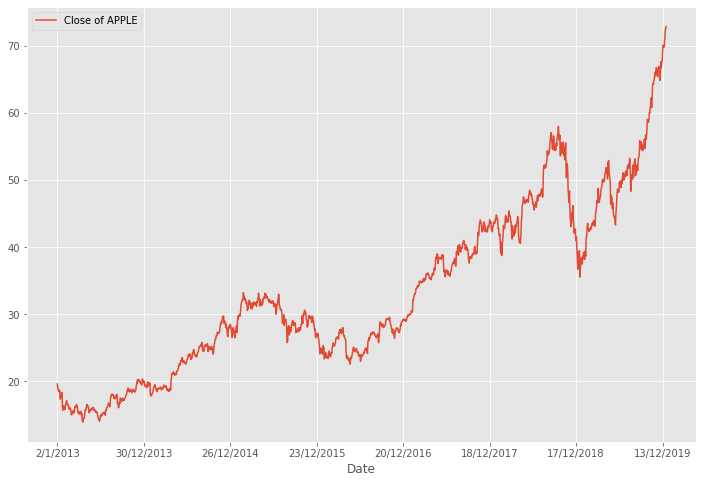

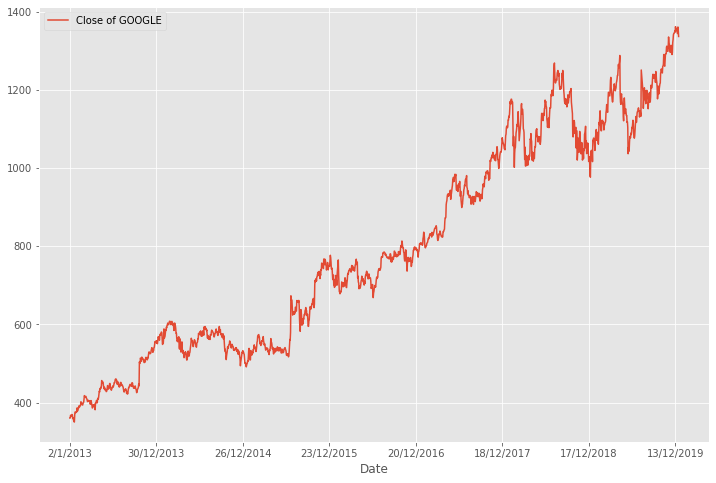

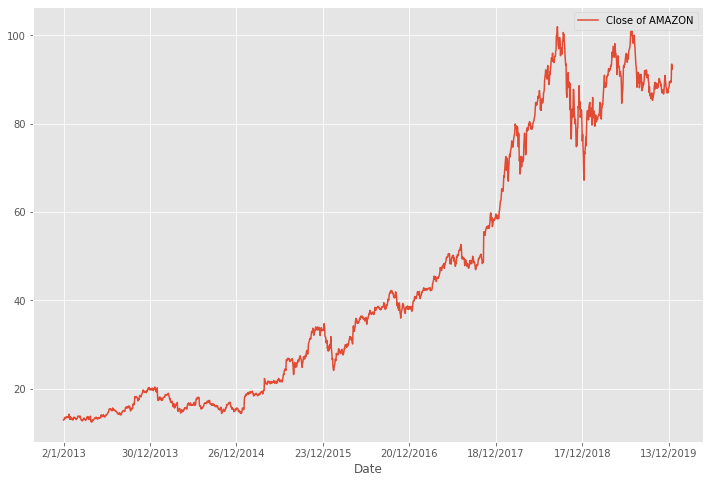

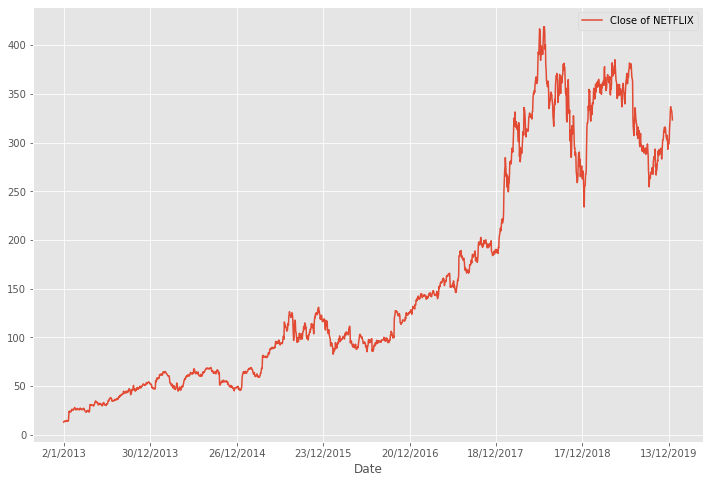

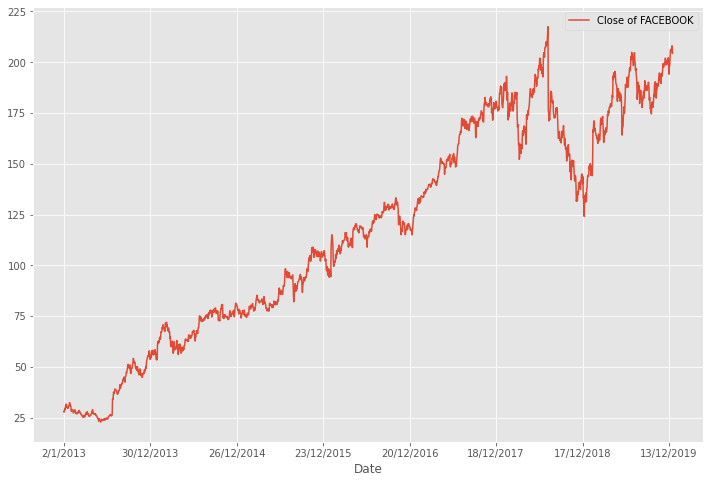

In [5]:
Actual_df=pd.read_csv("dataset.csv")
Actual_df.set_index("Date", inplace=True)
Actual_df.dropna(inplace=True)
company_names=Actual_df['company_name'].unique()
for name in company_names:
    df=Actual_df[Actual_df['company_name']== name]
    fig, ax = plt.subplots(figsize=(12, 8))
    Actual_label='Close of'+ ' '+ str(name) 
    df['Close'].plot(ax=ax, label=Actual_label)
    ax.legend();

# Modeling

We need to format the data in a way that each input contains stock prices of a 24-day period (t-24 to t-1) and the target is the price at time t. We can use a basic for loop as follows:

#LSTM

***************APPLE***************
LSTM Training RMSE: 9.25
LSTM Training MAPE: 7.18
LSTM Testing RMSE: 88.08
LSTM Training MAPE: 15.21
Fitting/Train Time in Second:117.497349
Test Data Prediction Time in Second:0.204501


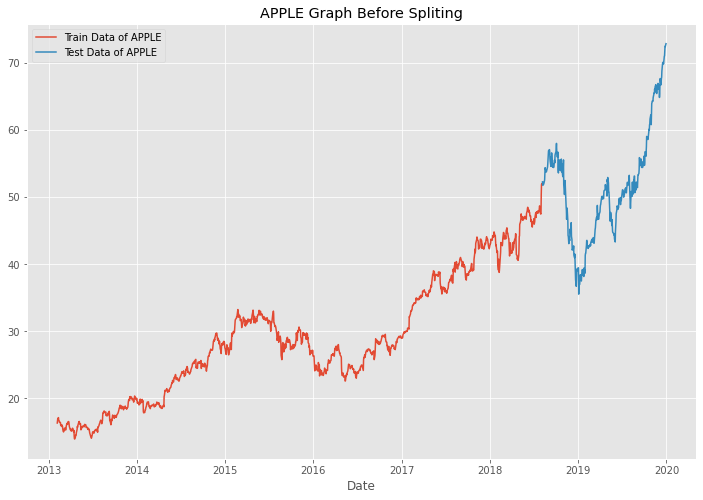

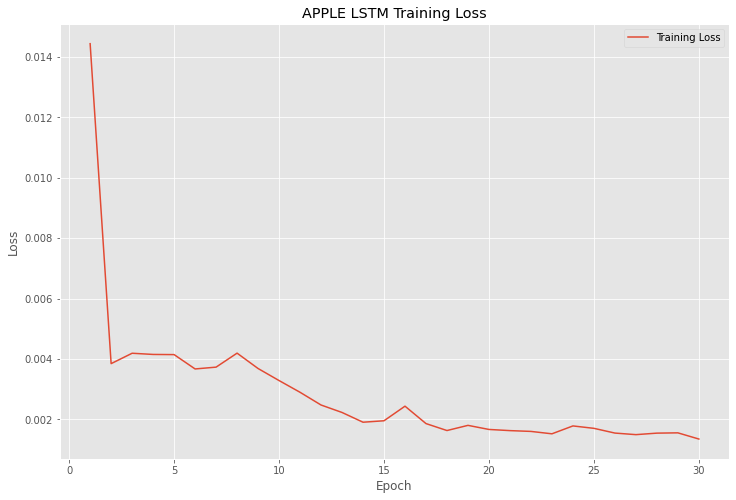

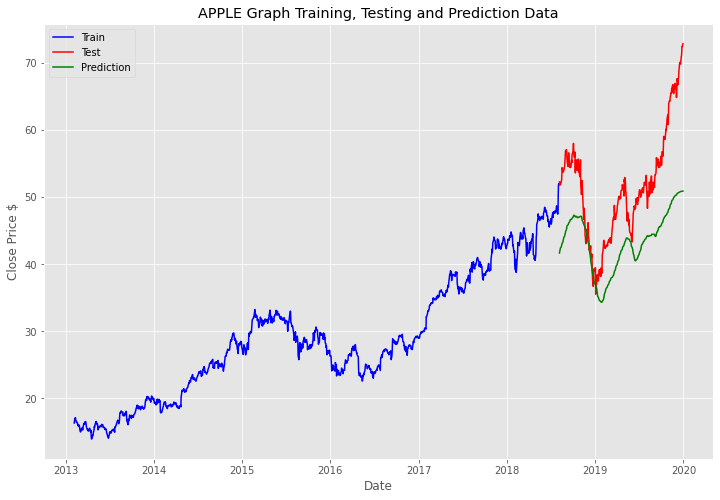

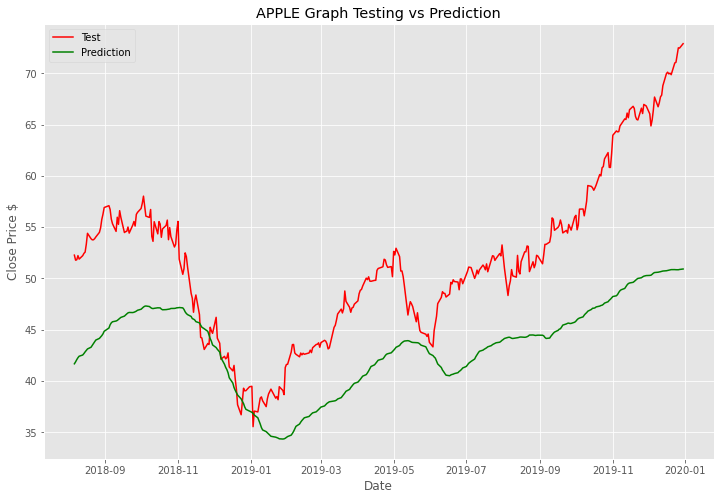

***************GOOGLE***************
LSTM Training RMSE: 4915.51
LSTM Training MAPE: 6.21
LSTM Testing RMSE: 21858.63
LSTM Training MAPE: 11.77
Fitting/Train Time in Second:117.244268
Test Data Prediction Time in Second:0.179539


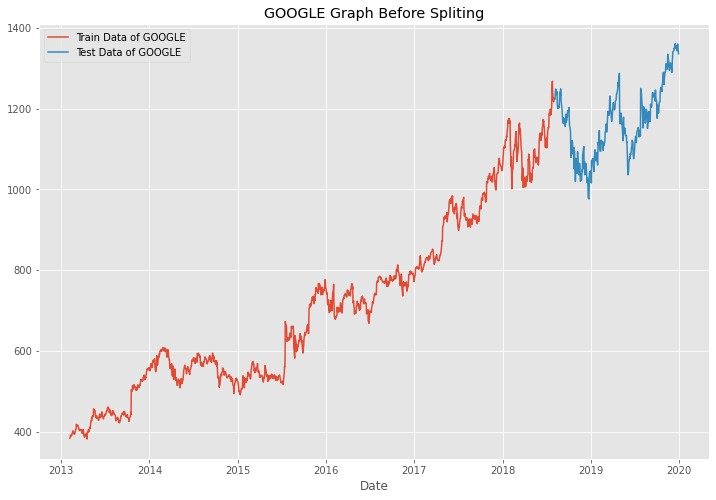

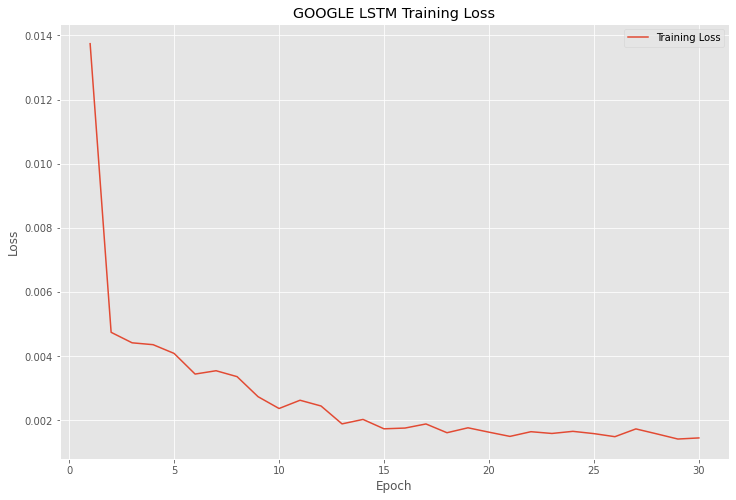

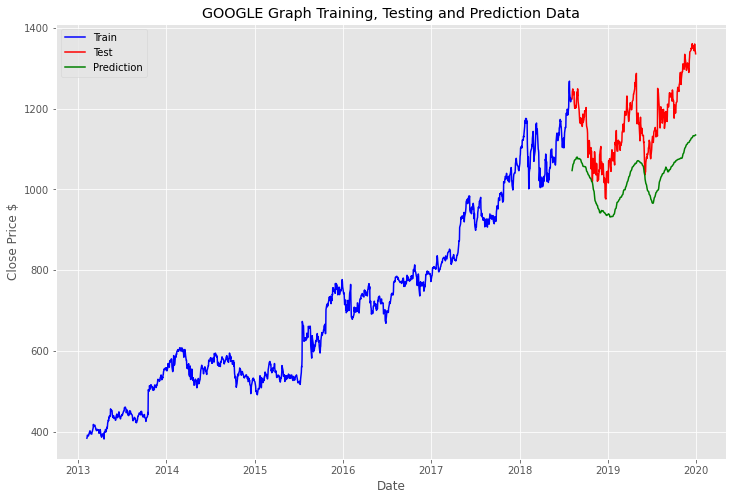

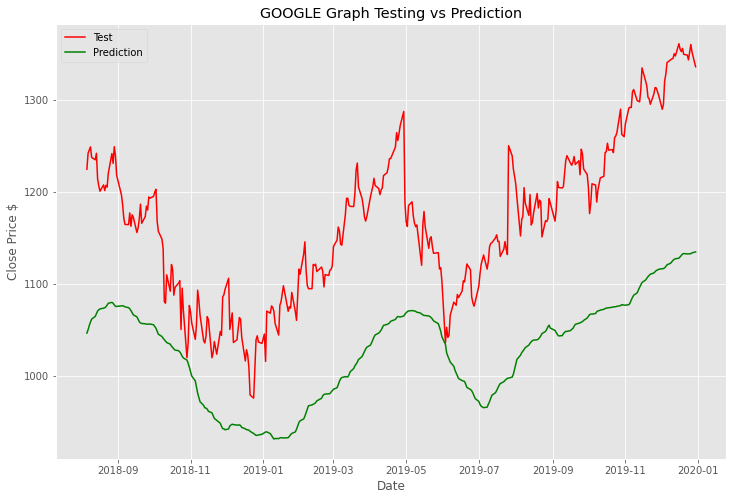

***************AMAZON***************
LSTM Training RMSE: 25.17
LSTM Training MAPE: 9.57
LSTM Testing RMSE: 174.14
LSTM Training MAPE: 13.73
Fitting/Train Time in Second:114.876189
Test Data Prediction Time in Second:0.382324


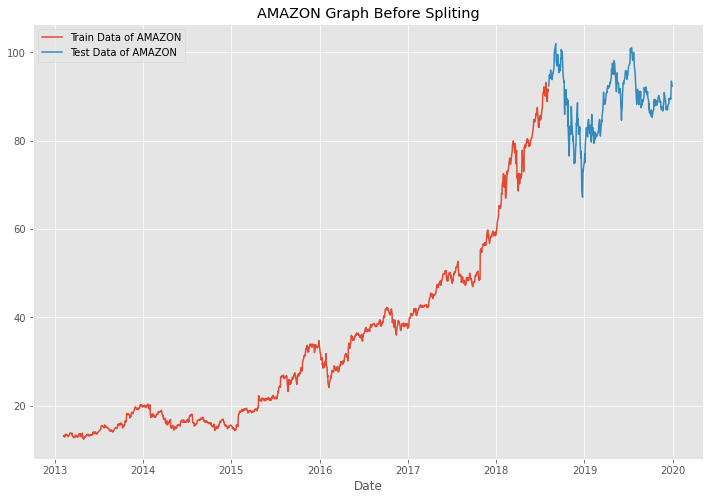

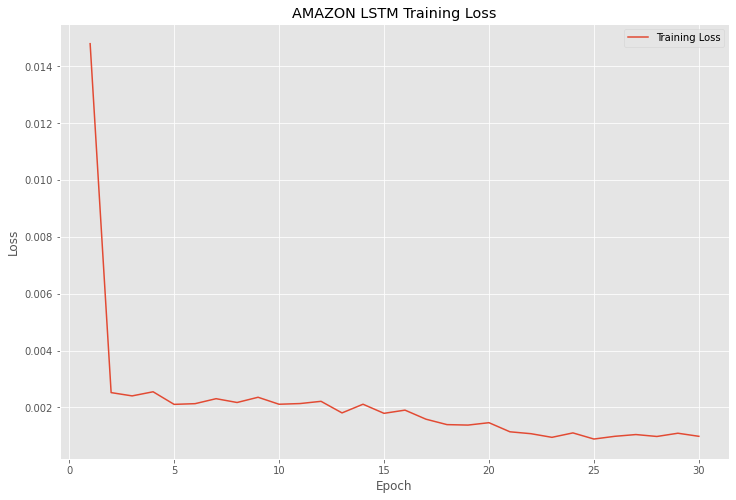

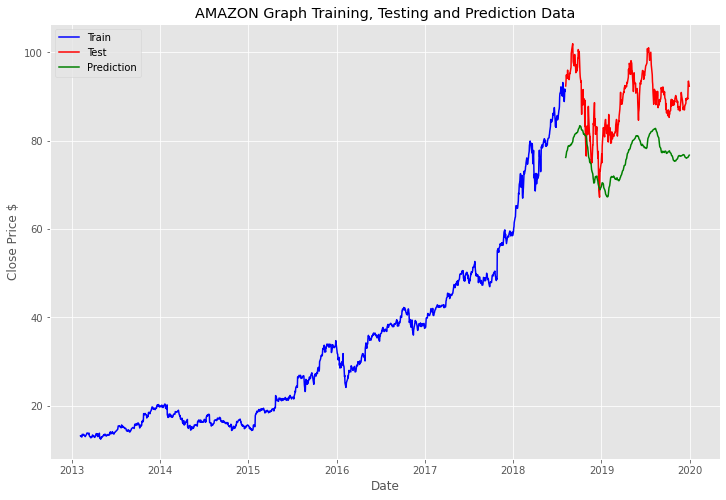

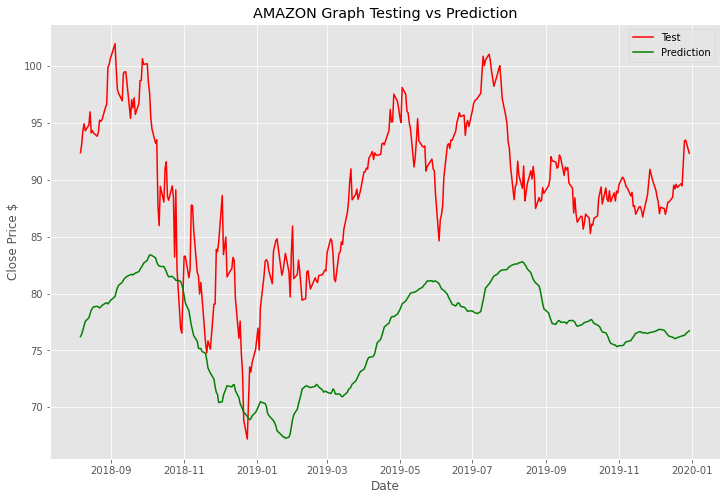

***************NETFLIX***************
LSTM Training RMSE: 418.23
LSTM Training MAPE: 10.03
LSTM Testing RMSE: 2245.92
LSTM Training MAPE: 12.82
Fitting/Train Time in Second:116.28173
Test Data Prediction Time in Second:0.181548


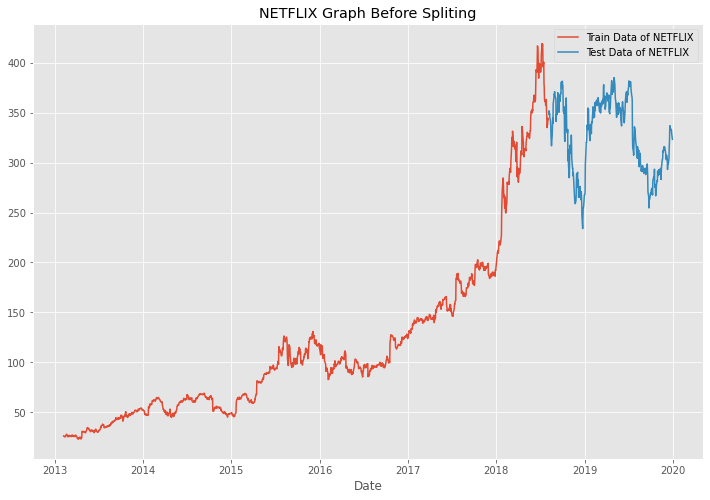

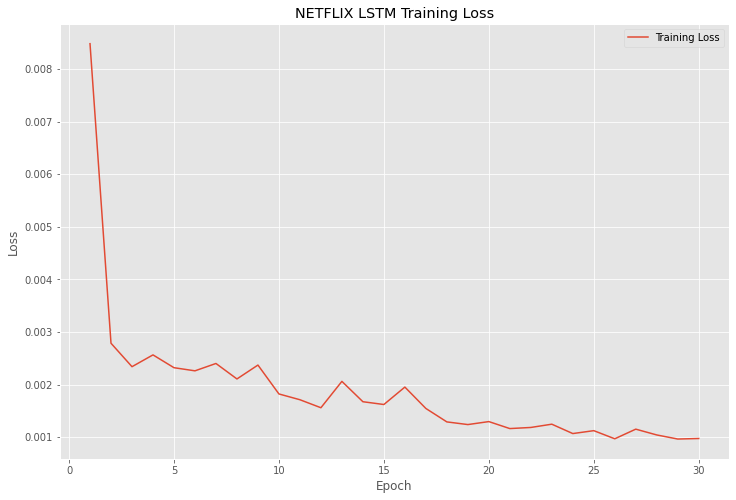

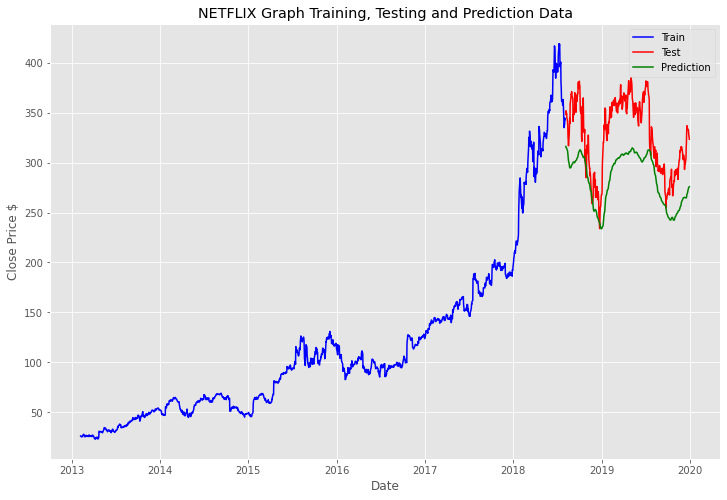

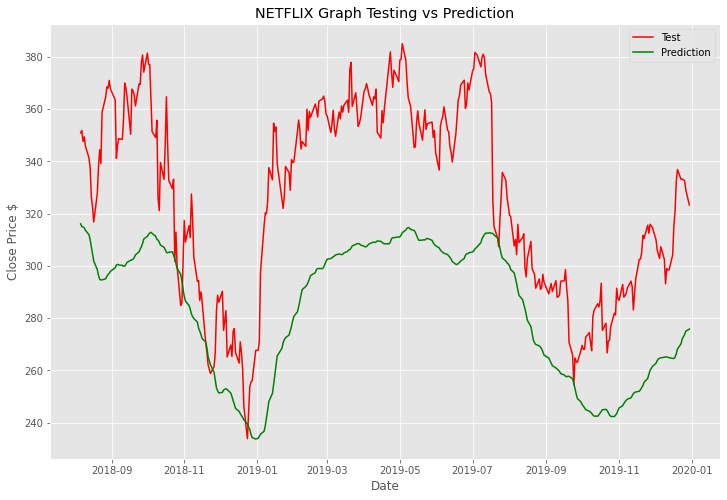

***************FACEBOOK***************
LSTM Training RMSE: 405.9
LSTM Training MAPE: 12.21
LSTM Testing RMSE: 1168.65
LSTM Training MAPE: 18.25
Fitting/Train Time in Second:116.212777
Test Data Prediction Time in Second:0.170131


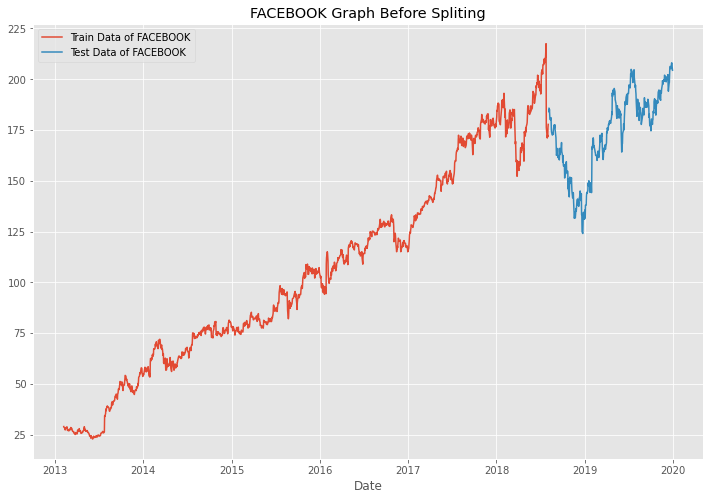

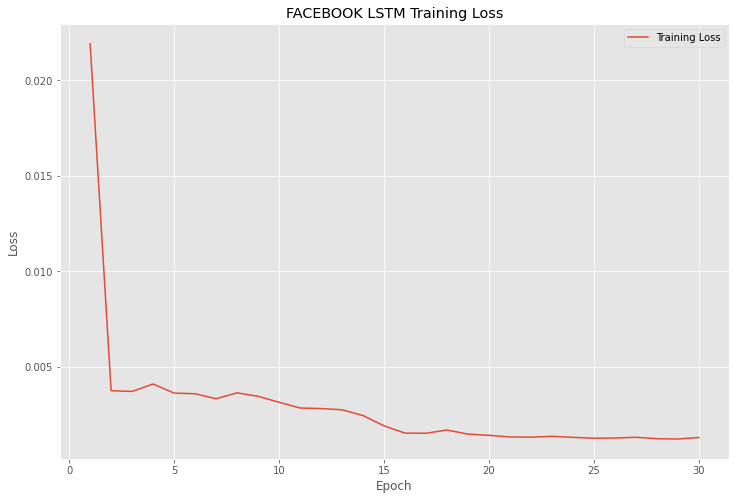

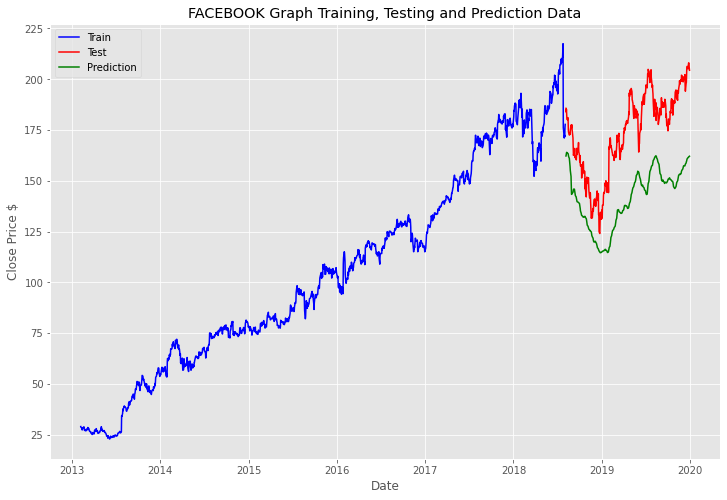

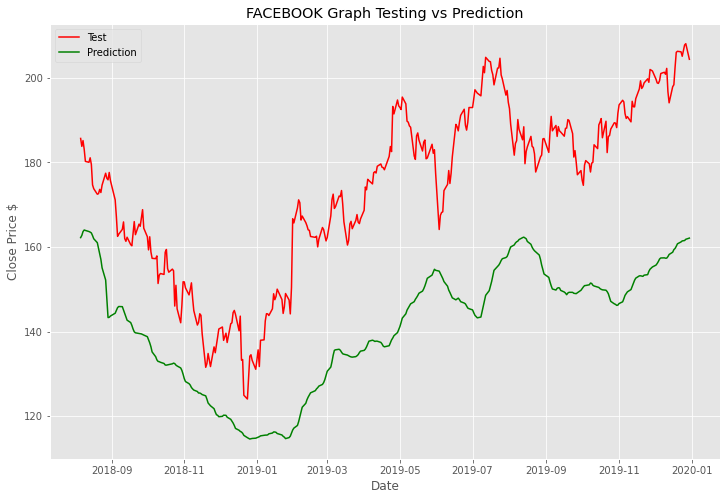

CPU times: user 15min 35s, sys: 46.7 s, total: 16min 22s
Wall time: 9min 56s


In [6]:
%%time
model_name = 'LSTM'
results = {'Model':[],'company_name':[],'RMSE_Train':[],'MAPE_Train':[],'RMSE_Test':[],'MAPE_Test':[],
                'Fit/Train_Time':[],'Test/Pred_Time':[]}
Actual_df=pd.read_csv("dataset.csv")
Actual_df.dropna(inplace=True)
company_names=Actual_df['company_name'].unique()
for name in company_names:
    df=Actual_df[Actual_df['company_name']== name]
    time = pd.to_datetime(df.pop('Date'), format='%d/%m/%Y')
    series = df['Close']
    series.index = time
    def split_sequence(sequence, window_size):
      X = []
      y = []
      # for all indexes
      for i in range(len(sequence)):
          end_idx = i + window_size
          # exit condition
          if end_idx > len(sequence)-1:
              break
          # get X and Y values
          seq_x, seq_y = sequence[i:end_idx], sequence[end_idx]
          X.append(seq_x)
          y.append(seq_y)
      return np.array(X), np.array(y)
    train = series[:int(len(series)*0.8)]
    test = series[int(len(series)*0.8)-24:]
    
    X_train, y_train = split_sequence(train, window_size=24)
    X_test, y_test = split_sequence(test, window_size=24)
    
    #Scaling the data using min max saclar between 0 -1
    sc = MinMaxScaler()
    X_train_scaled = sc.fit_transform(X_train)
    X_test_scaled = sc.transform(X_test)
    y_train_scaled = sc.fit_transform(y_train.reshape(-1,1))
    y_test_scaled = sc.transform(y_test.reshape(-1,1))
    
    # Model requires 3D input
    X_train_scaled = X_train_scaled.reshape((len(X_train_scaled), 24, 1)) # window =24 
    X_test_scaled = X_test_scaled.reshape((len(X_test_scaled), 24, 1))    # window =24
    
    # LSTM Model
    model = Sequential()
    model.add(layers.LSTM(units=64, return_sequences=True, input_shape=(24,1), dropout=0.2))
    model.add(layers.LSTM(units=32, return_sequences=True, dropout=0.2))
    model.add(layers.LSTM(units=32, return_sequences=True, dropout=0.2))
    model.add(layers.LSTM(units=16, dropout=0.2))
    model.add(layers.Dense(units=1))
  #   #model.summary()
    
  #   #Optimizer

    opt = Adam(learning_rate=0.001)
    # Model Compile

    model.compile(optimizer= opt, loss='mean_squared_error')
    
    start_fitting = dt.now()
    print("***************"+str(name)+"***************")
    history = model.fit(X_train_scaled, y_train_scaled, epochs=30, batch_size=16,verbose=0)
    
    #Training
    pred_train = model.predict(X_train_scaled)
    pred_transformed_train = sc.inverse_transform(pred_train).ravel()
    y_train_transformed = sc.inverse_transform(y_train_scaled).ravel()
    
    rmse_train = mean_squared_error(y_train_transformed,pred_transformed_train)
    mape_train = mean_absolute_percentage_error(y_train_transformed,pred_transformed_train)
    print('LSTM Training RMSE: '+str(round(rmse_train,2)))
    print('LSTM Training MAPE: '+str(round(mape_train*100,2)))
    fitting_secs = (dt.now() - start_fitting).total_seconds()
    
    # Testing
    start_x_testing = dt.now()
    pred_test = model.predict(X_test_scaled)
    pred_transformed_test = sc.inverse_transform(pred_test).ravel()
    y_test_transformed = sc.inverse_transform(y_test_scaled).ravel()
    rmse_test = mean_squared_error(y_test_transformed,pred_transformed_test)
    mape_test = mean_absolute_percentage_error(y_test_transformed,pred_transformed_test)
    print('LSTM Testing RMSE: '+str(round(rmse_test,2)))
    print('LSTM Training MAPE: '+str(round(mape_test*100,2)))
    
    x_testing_secs = (dt.now() - start_x_testing).total_seconds()
    print('Fitting/Train Time in Second:'+str(fitting_secs))
    print('Test Data Prediction Time in Second:'+str(x_testing_secs))

    #Spliting Graph
    plt.figure(figsize=(12,8))
    plt.plot(pd.Series(y_train, index=train[24:].index), label='Train Data of'+ ' '+ str(name) )
    plt.plot(pd.Series(y_test, index=test[24:].index), label='Test Data of'+ ' '+ str(name) )
    label=str(name)+' Graph Before Spliting'
    plt.xlabel('Date')
    plt.title(label)
    plt.legend()
    plt.show()
    
  #   #Model Loss
    loss = history.history['loss']
    epoch_count = range(1, len(loss) + 1)
    plt.figure(figsize=(12,8))
    plt.plot(epoch_count, loss)
    plt.legend(['Training Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    label = str(name)+ ' ' + model_name + ' Training Loss'
    plt.title(label)
    plt.show()
    
    #Model Performance Graphs
    plt.figure(figsize=(12,8))
    plt.plot(pd.Series(y_train_transformed, index=train[24:].index),color='blue', label='Train')
    plt.plot(pd.Series(y_test_transformed, index=test[24:].index),color='red', label='Test')
    plt.plot(pd.Series(pred_transformed_test, index=test[24:].index),color='green', label='Prediction')
    plt.xlabel('Date')
    plt.ylabel('Close Price $')
    label=str(name)+' Graph Training, Testing and Prediction Data'
    plt.title(label)
    plt.legend()
    plt.show()

    plt.figure(figsize=(12,8))
    plt.plot(pd.Series(y_test_transformed, index=test[24:].index),color='red', label='Test')
    plt.plot(pd.Series(pred_transformed_test, index=test[24:].index),color='green', label='Prediction')
    plt.xlabel('Date')
    plt.ylabel('Close Price $')
    label=str(name)+' Graph Testing vs Prediction'
    plt.title(label)
    plt.legend()
    plt.show()
    del model
    del history
    # Results
    results['Model'].append(model_name)
    results['company_name'].append(name)
    results['RMSE_Train'].append(rmse_train)
    results['MAPE_Train'].append(mape_train*100)
    results['RMSE_Test'].append(rmse_test)
    results['MAPE_Test'].append(mape_test*100)
    results['Fit/Train_Time'].append(fitting_secs)
    results['Test/Pred_Time'].append(x_testing_secs)


# CNN

***************APPLE***************
CNN Training RMSE: 0.44
CNN Training MAPE: 1.69
CNN Testing RMSE: 2.63
CNN Training MAPE: 2.36
Fitting/Train Time in Second:10.918839
Test Data Prediction Time in Second:0.067212


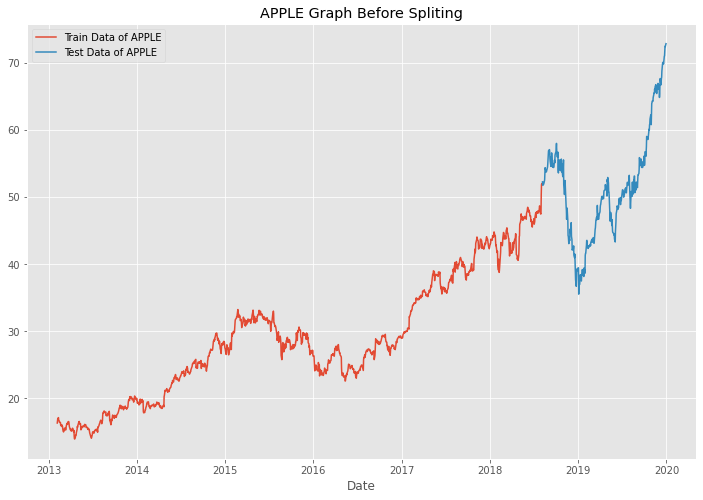

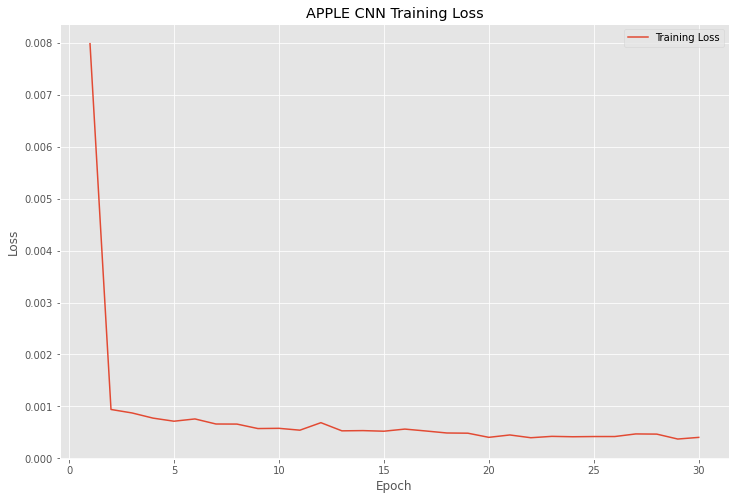

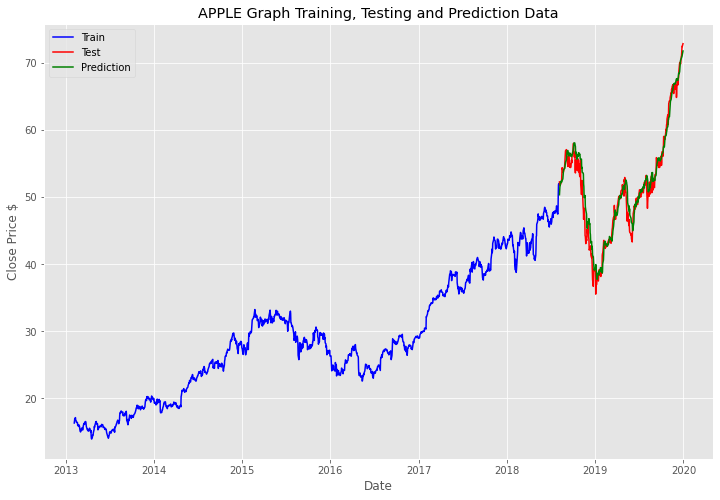

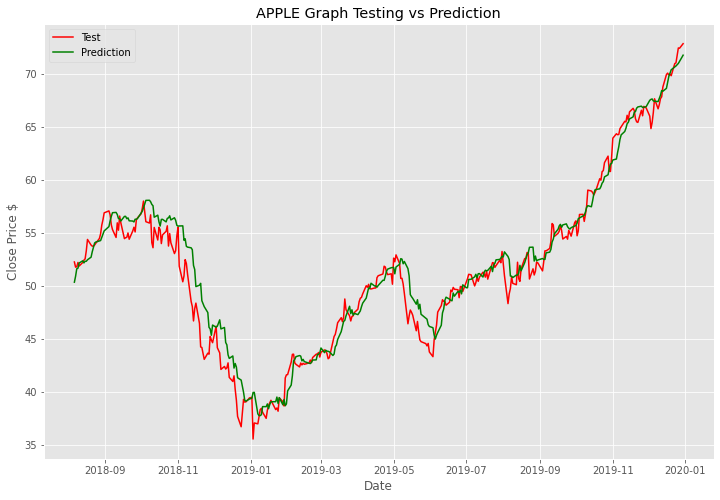

***************GOOGLE***************
CNN Training RMSE: 257.64
CNN Training MAPE: 1.6
CNN Testing RMSE: 834.36
CNN Training MAPE: 1.88
Fitting/Train Time in Second:10.896378
Test Data Prediction Time in Second:0.071517


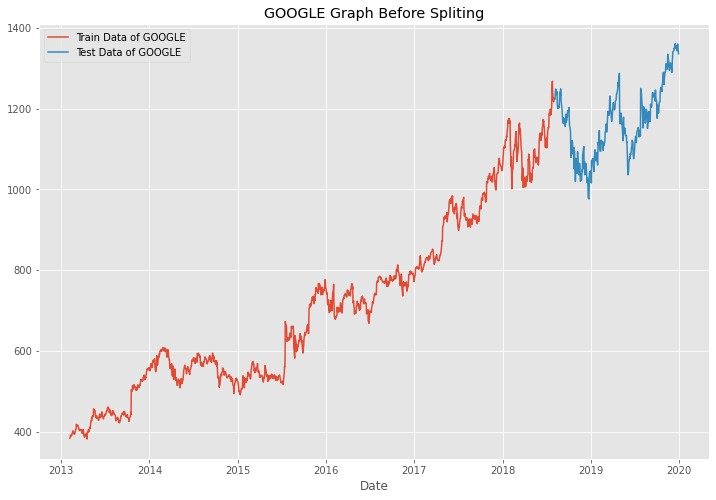

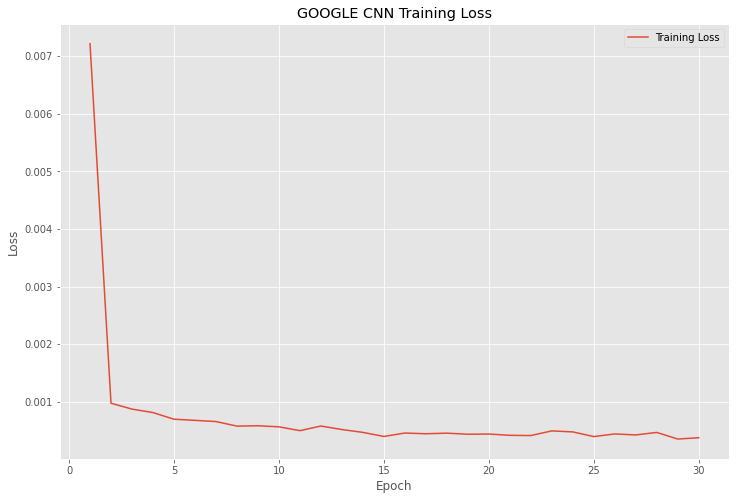

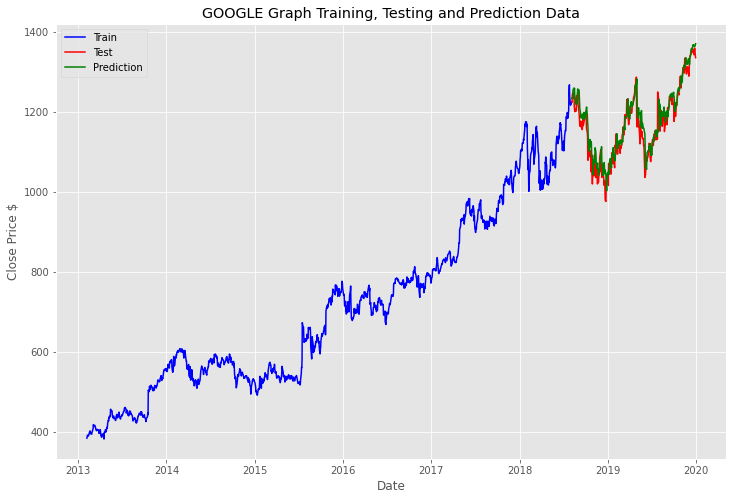

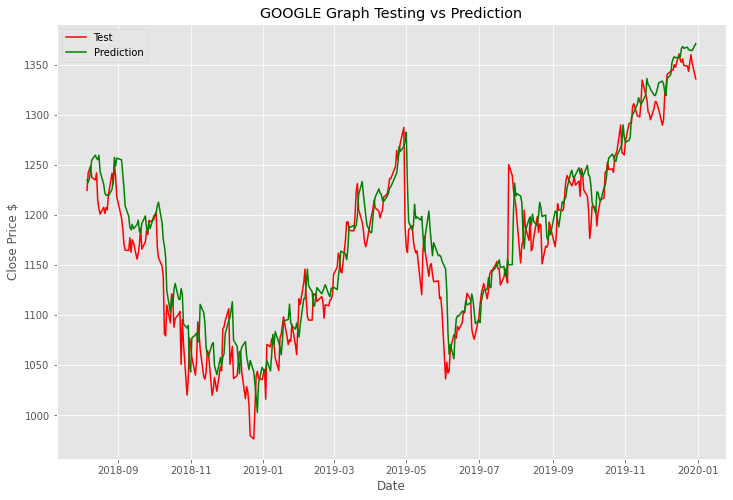

***************AMAZON***************
CNN Training RMSE: 1.87
CNN Training MAPE: 2.68
CNN Testing RMSE: 16.94
CNN Training MAPE: 3.77
Fitting/Train Time in Second:6.665494
Test Data Prediction Time in Second:0.143945


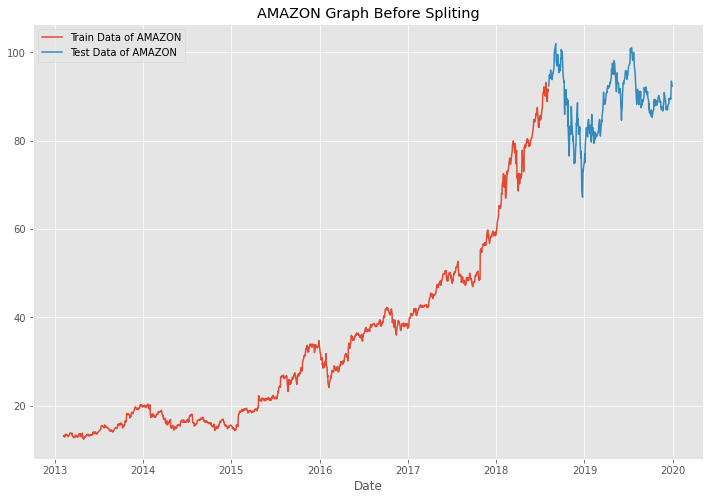

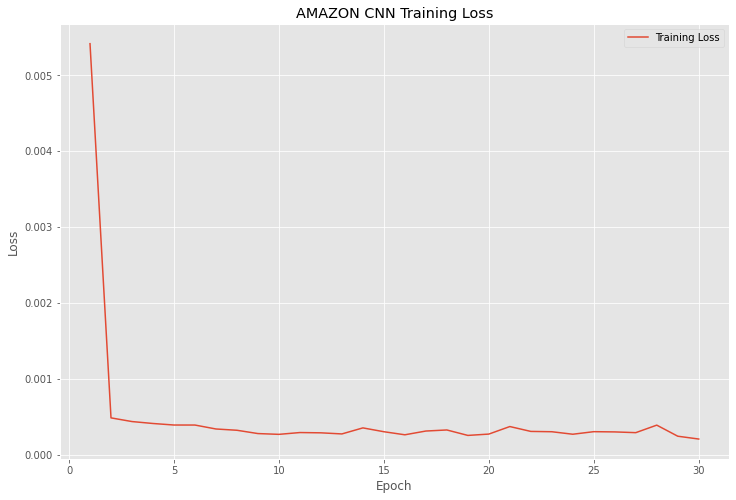

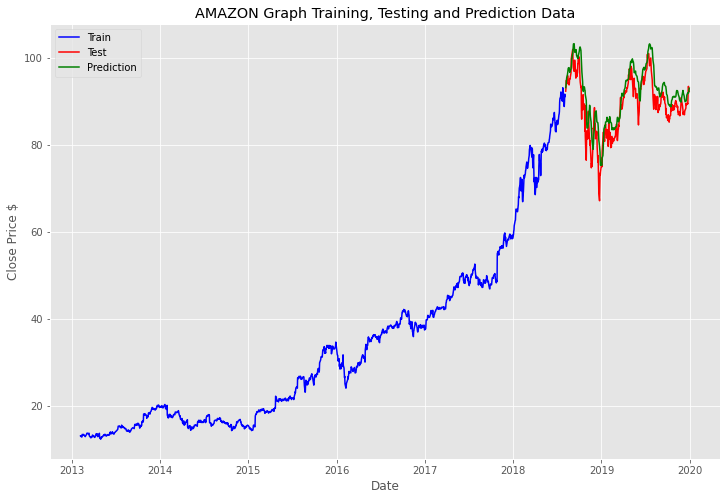

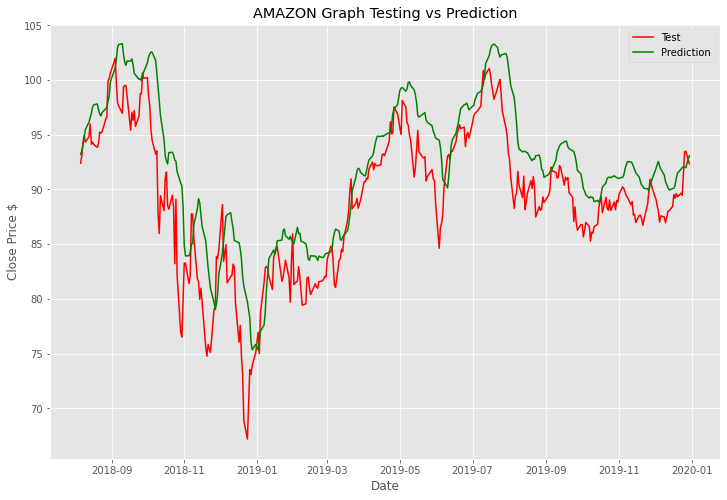

***************NETFLIX***************
CNN Training RMSE: 57.73
CNN Training MAPE: 4.29
CNN Testing RMSE: 455.96
CNN Training MAPE: 5.57
Fitting/Train Time in Second:11.086371
Test Data Prediction Time in Second:0.071116


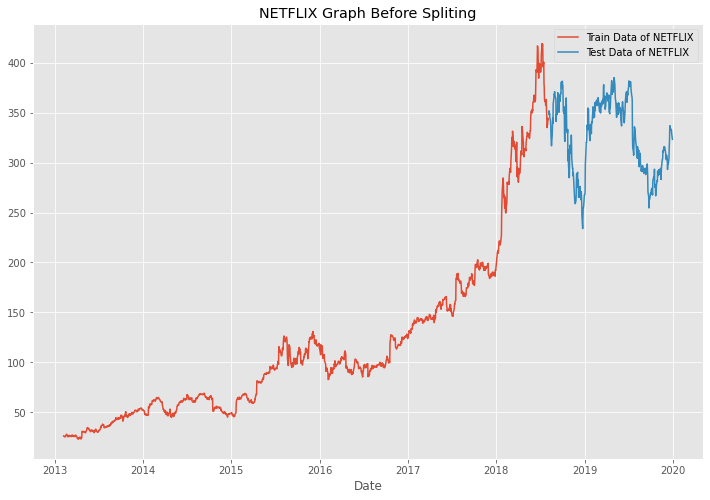

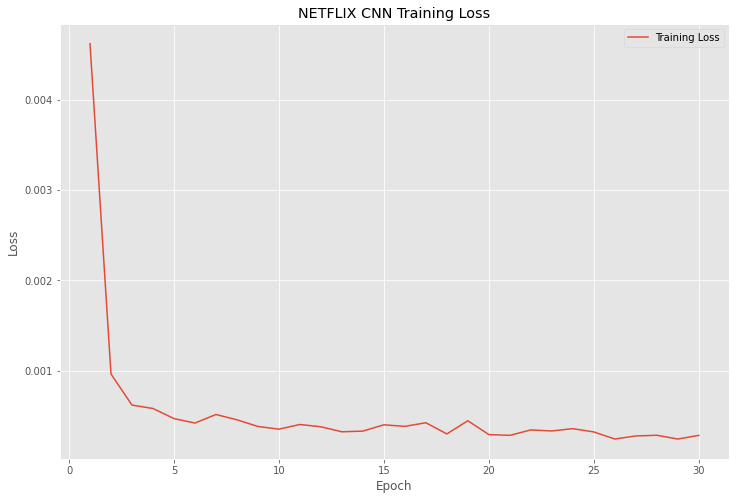

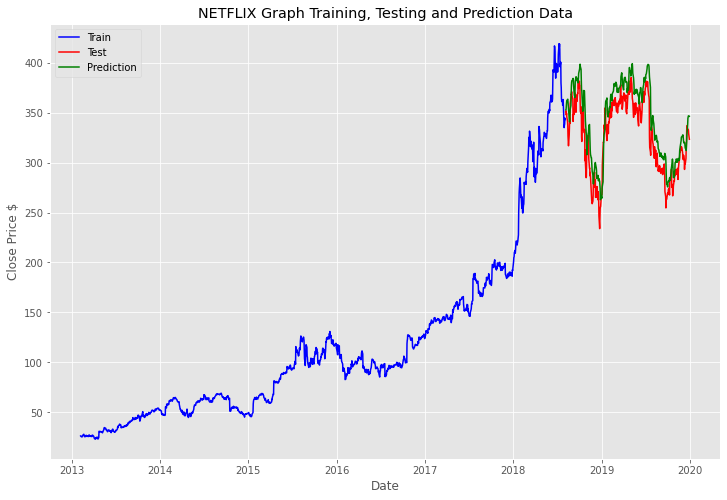

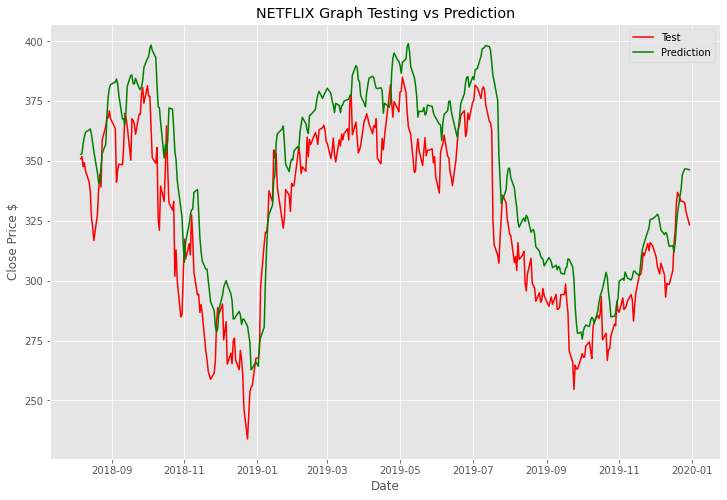

***************FACEBOOK***************
CNN Training RMSE: 14.48
CNN Training MAPE: 2.74
CNN Testing RMSE: 32.47
CNN Training MAPE: 2.67
Fitting/Train Time in Second:6.181159
Test Data Prediction Time in Second:0.066568


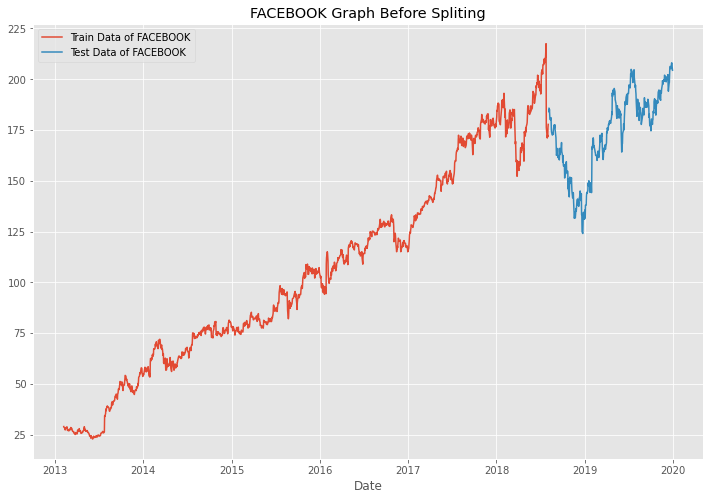

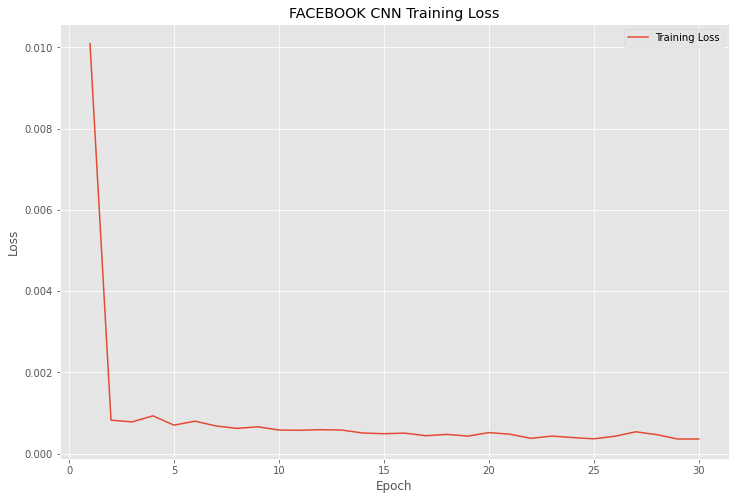

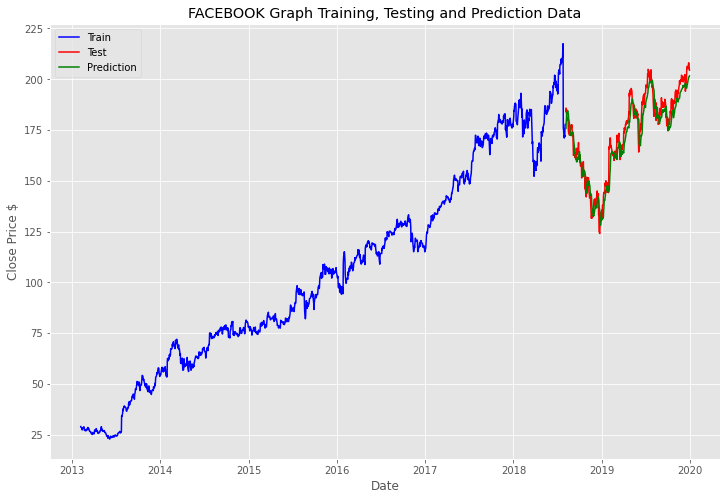

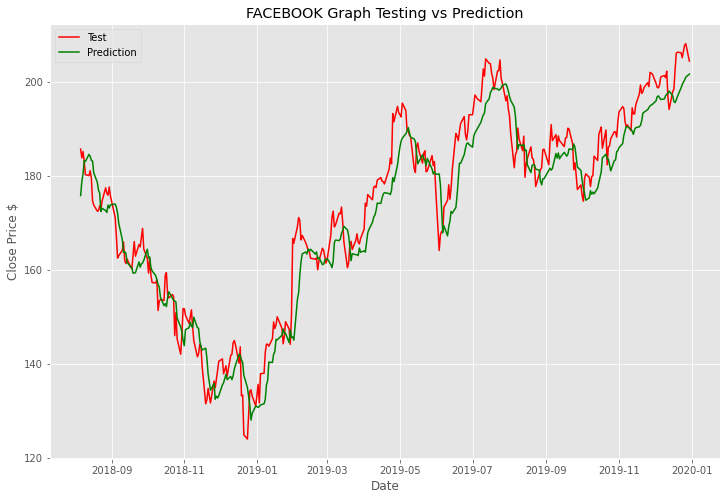

CPU times: user 47.4 s, sys: 2.72 s, total: 50.1 s
Wall time: 53.3 s


In [7]:
%%time
model_name = 'CNN'
Actual_df=pd.read_csv("dataset.csv")
Actual_df.dropna(inplace=True)
company_names=Actual_df['company_name'].unique()
for name in company_names:
    df=Actual_df[Actual_df['company_name']== name]
    time = pd.to_datetime(df.pop('Date'), format='%d/%m/%Y')
    series = df['Close']
    series.index = time
    def split_sequence(sequence, window_size):
      X = []
      y = []
      # for all indexes
      for i in range(len(sequence)):
          end_idx = i + window_size
          # exit condition
          if end_idx > len(sequence)-1:
              break
          # get X and Y values
          seq_x, seq_y = sequence[i:end_idx], sequence[end_idx]
          X.append(seq_x)
          y.append(seq_y)
      return np.array(X), np.array(y)
    train = series[:int(len(series)*0.8)]
    test = series[int(len(series)*0.8)-24:]
    
    X_train, y_train = split_sequence(train, window_size=24)
    X_test, y_test = split_sequence(test, window_size=24)
    
    #Scaling the data using min max saclar between 0 -1
    sc = MinMaxScaler()
    X_train_scaled = sc.fit_transform(X_train)
    X_test_scaled = sc.transform(X_test)
    y_train_scaled = sc.fit_transform(y_train.reshape(-1,1))
    y_test_scaled = sc.transform(y_test.reshape(-1,1))
    
    # Model requires 3D input
    X_train_scaled = X_train_scaled.reshape((len(X_train_scaled), 24, 1)) # window =24 
    X_test_scaled = X_test_scaled.reshape((len(X_test_scaled), 24, 1))    # window =24

    
    # CNN Model
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(24,1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))

    #model.summary()
    
    #Optimizer

    opt = Adam(learning_rate=0.001)
    # Model Compile

    model.compile(optimizer= opt, loss='mean_squared_error')
    
    start_fitting = dt.now()
    print("***************"+str(name)+"***************")
    history = model.fit(X_train_scaled, y_train_scaled, epochs=30, batch_size=16,verbose=0)
    
    #Training
    pred_train = model.predict(X_train_scaled)
    pred_transformed_train = sc.inverse_transform(pred_train).ravel()
    y_train_transformed = sc.inverse_transform(y_train_scaled).ravel()
    
    rmse_train = mean_squared_error(y_train_transformed,pred_transformed_train)
    mape_train = mean_absolute_percentage_error(y_train_transformed,pred_transformed_train)
    print('CNN Training RMSE: '+str(round(rmse_train,2)))
    print('CNN Training MAPE: '+str(round(mape_train*100,2)))
    fitting_secs = (dt.now() - start_fitting).total_seconds()
    
    # Testing
    start_x_testing = dt.now()
    pred_test = model.predict(X_test_scaled)
    pred_transformed_test = sc.inverse_transform(pred_test).ravel()
    y_test_transformed = sc.inverse_transform(y_test_scaled).ravel()
    
    rmse_test = mean_squared_error(y_test_transformed,pred_transformed_test)
    mape_test = mean_absolute_percentage_error(y_test_transformed,pred_transformed_test)
    print('CNN Testing RMSE: '+str(round(rmse_test,2)))
    print('CNN Training MAPE: '+str(round(mape_test*100,2)))
    x_testing_secs = (dt.now() - start_x_testing).total_seconds()
    print('Fitting/Train Time in Second:'+str(fitting_secs))
    print('Test Data Prediction Time in Second:'+str(x_testing_secs))
    
    #Spliting Graph
    plt.figure(figsize=(12,8))
    plt.plot(pd.Series(y_train, index=train[24:].index), label='Train Data of'+ ' '+ str(name) )
    plt.plot(pd.Series(y_test, index=test[24:].index), label='Test Data of'+ ' '+ str(name) )
    label=str(name)+' Graph Before Spliting'
    plt.xlabel('Date')
    plt.title(label)
    plt.legend()
    plt.show()
    
   #   #Model Loss
    loss = history.history['loss']
    epoch_count = range(1, len(loss) + 1)
    plt.figure(figsize=(12,8))
    plt.plot(epoch_count, loss)
    plt.legend(['Training Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    label = str(name)+ ' ' + model_name + ' Training Loss'
    plt.title(label)
    plt.show()
    
    #Model Performance Graphs
    plt.figure(figsize=(12,8))
    plt.plot(pd.Series(y_train_transformed, index=train[24:].index),color='blue', label='Train')
    plt.plot(pd.Series(y_test_transformed, index=test[24:].index),color='red', label='Test')
    plt.plot(pd.Series(pred_transformed_test, index=test[24:].index),color='green', label='Prediction')
    plt.xlabel('Date')
    plt.ylabel('Close Price $')
    label=str(name)+' Graph Training, Testing and Prediction Data'
    plt.title(label)
    plt.legend()
    plt.show()

    plt.figure(figsize=(12,8))
    plt.plot(pd.Series(y_test_transformed, index=test[24:].index),color='red', label='Test')
    plt.plot(pd.Series(pred_transformed_test, index=test[24:].index),color='green', label='Prediction')
    plt.xlabel('Date')
    plt.ylabel('Close Price $')
    label=str(name)+' Graph Testing vs Prediction'
    plt.title(label)
    plt.legend()
    plt.show()
    del model
    del history
    results['Model'].append(model_name)
    results['company_name'].append(name)
    results['RMSE_Train'].append(rmse_train)
    results['MAPE_Train'].append(mape_train*100)
    results['RMSE_Test'].append(rmse_test)
    results['MAPE_Test'].append(mape_test*100)
    results['Fit/Train_Time'].append(fitting_secs)
    results['Test/Pred_Time'].append(x_testing_secs)

# GRU

***************APPLE***************
GRU Training RMSE: 0.81
GRU Training MAPE: 2.25
GRU Testing RMSE: 8.16
GRU Training MAPE: 4.46
Fitting/Train Time in Second:130.265989
Test Data Prediction Time in Second:0.192831


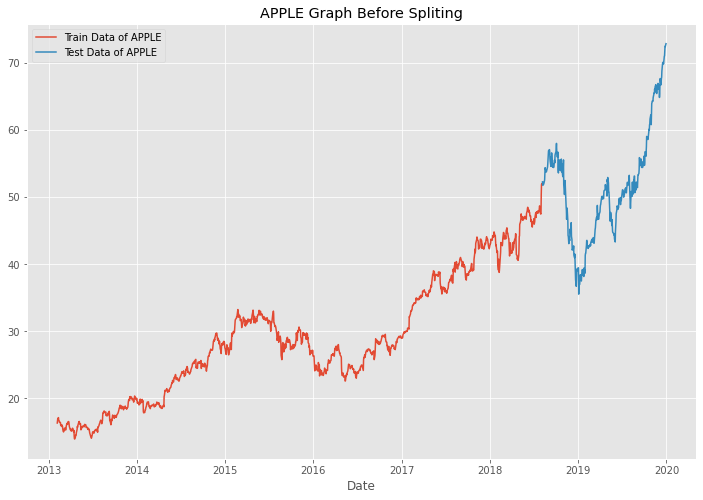

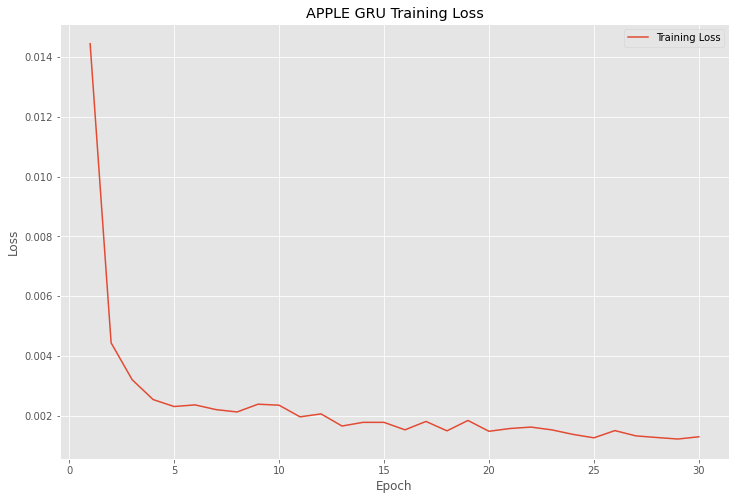

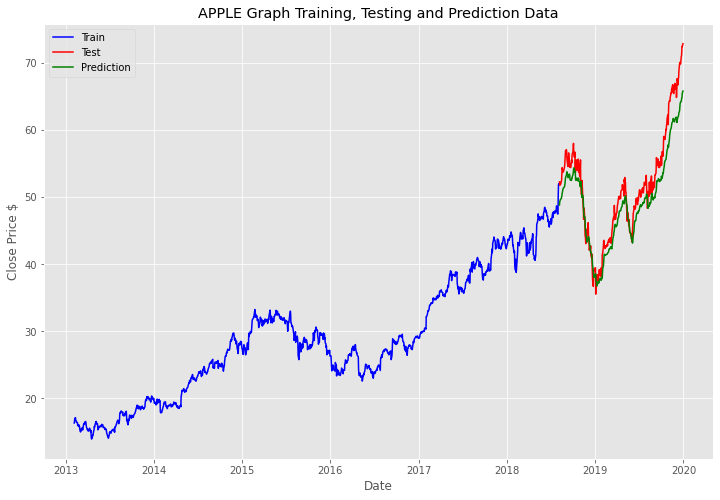

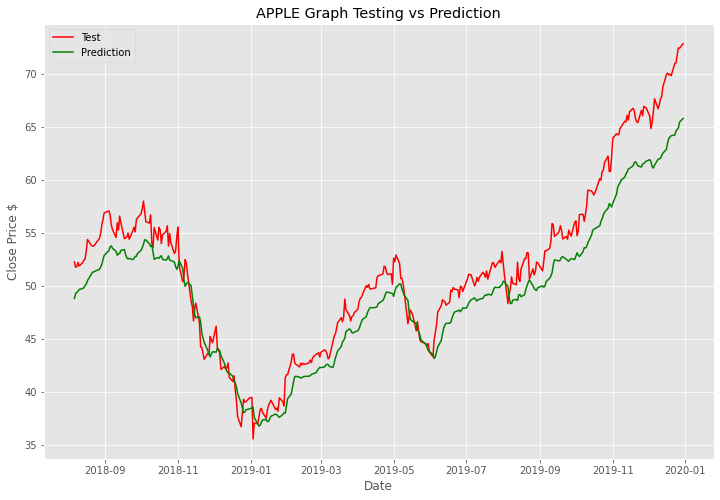

***************GOOGLE***************
GRU Training RMSE: 250.26
GRU Training MAPE: 1.55
GRU Testing RMSE: 864.77
GRU Training MAPE: 2.05
Fitting/Train Time in Second:132.882861
Test Data Prediction Time in Second:0.185066


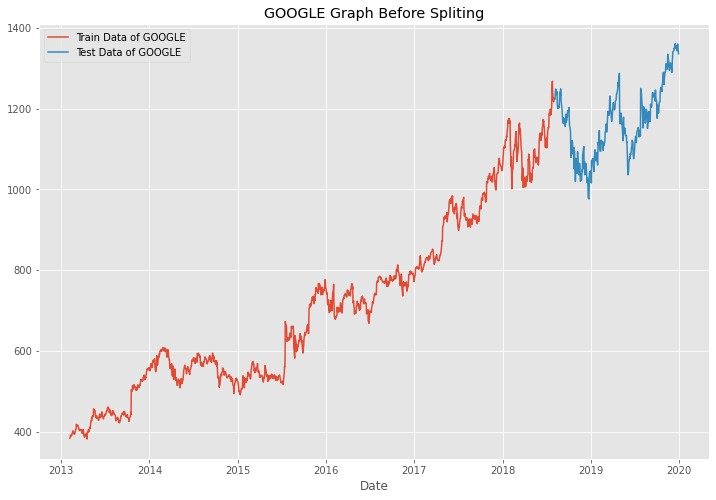

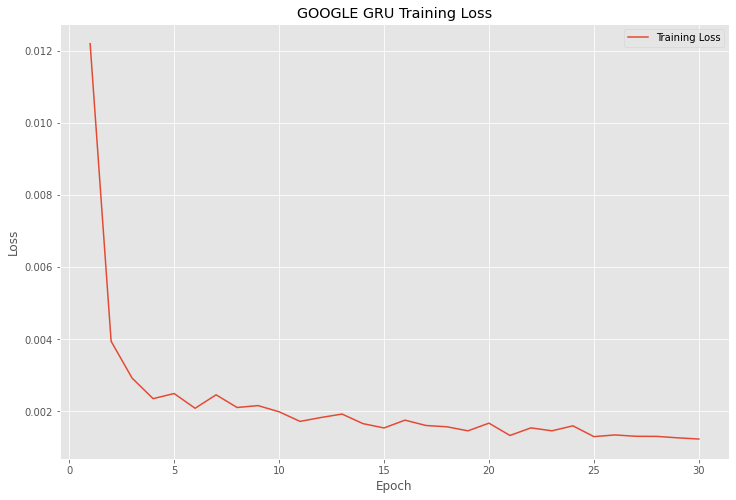

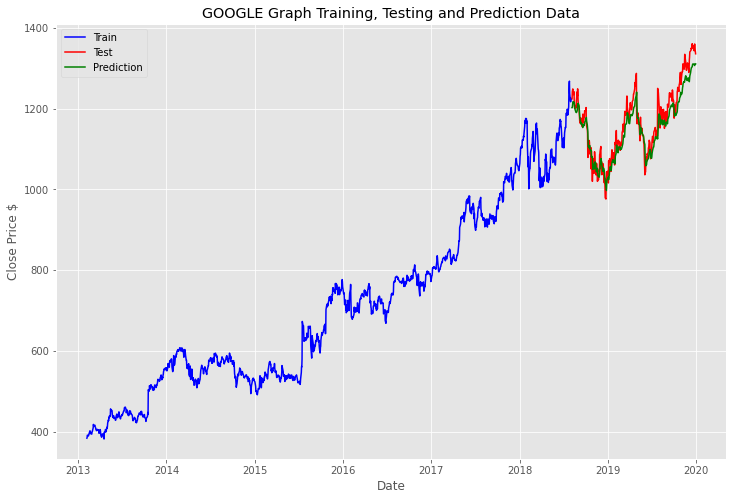

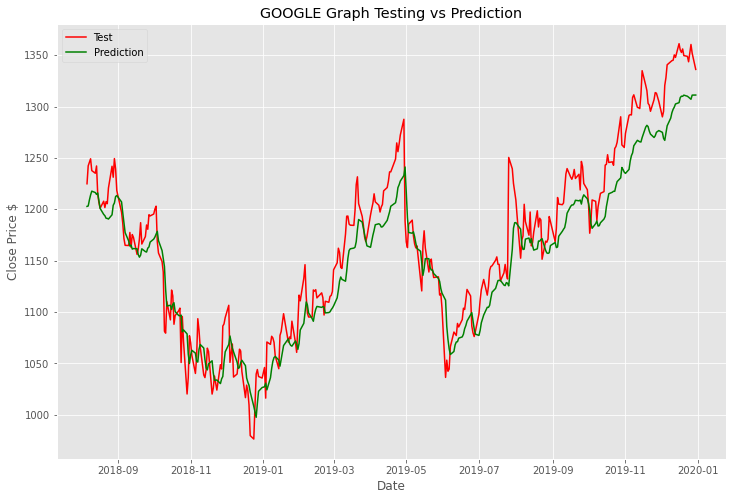

***************AMAZON***************
GRU Training RMSE: 3.24
GRU Training MAPE: 6.92
GRU Testing RMSE: 9.41
GRU Training MAPE: 2.63
Fitting/Train Time in Second:131.027609
Test Data Prediction Time in Second:0.199977


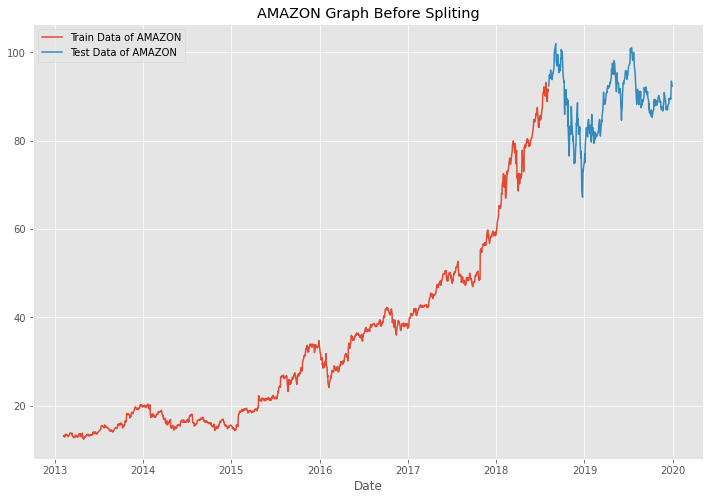

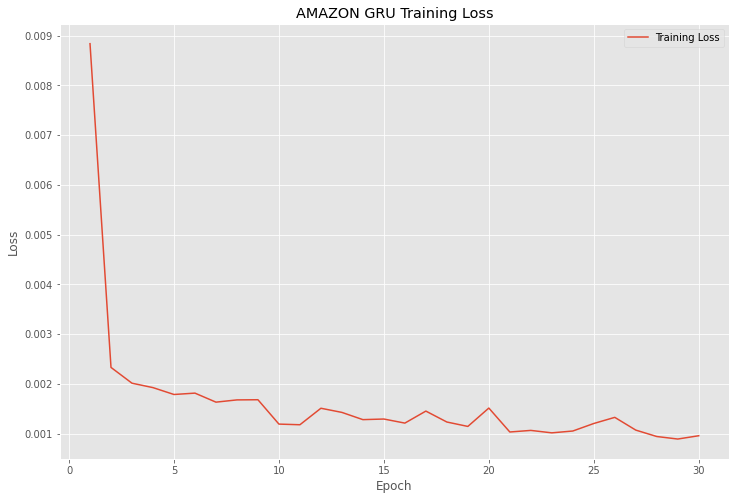

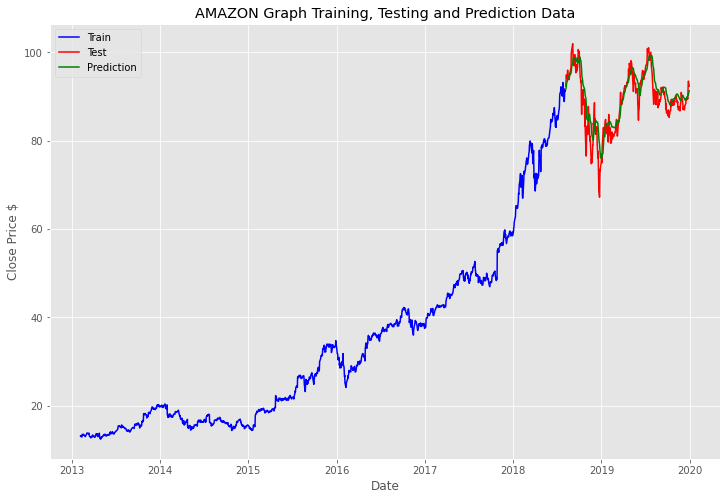

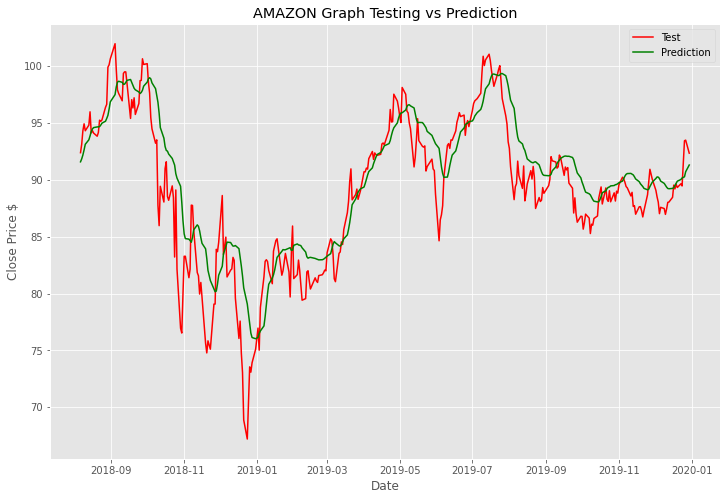

***************NETFLIX***************
GRU Training RMSE: 77.78
GRU Training MAPE: 7.97
GRU Testing RMSE: 342.1
GRU Training MAPE: 4.78
Fitting/Train Time in Second:133.882244
Test Data Prediction Time in Second:0.192858


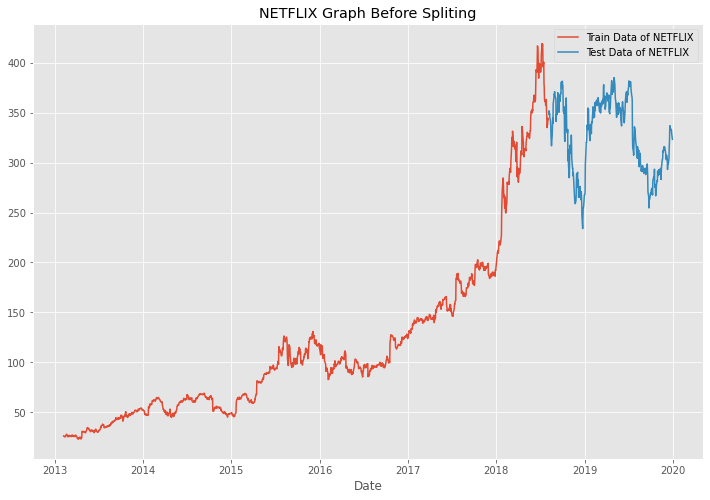

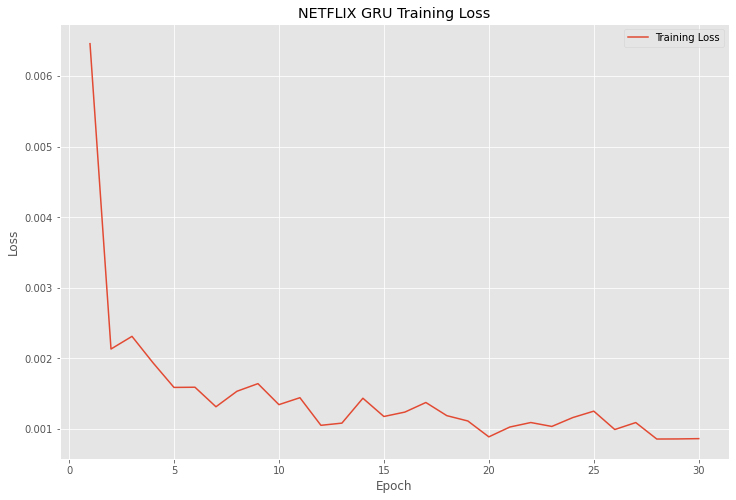

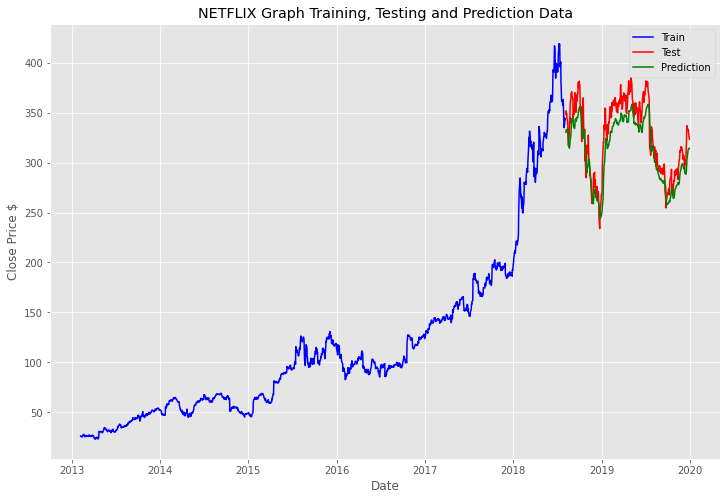

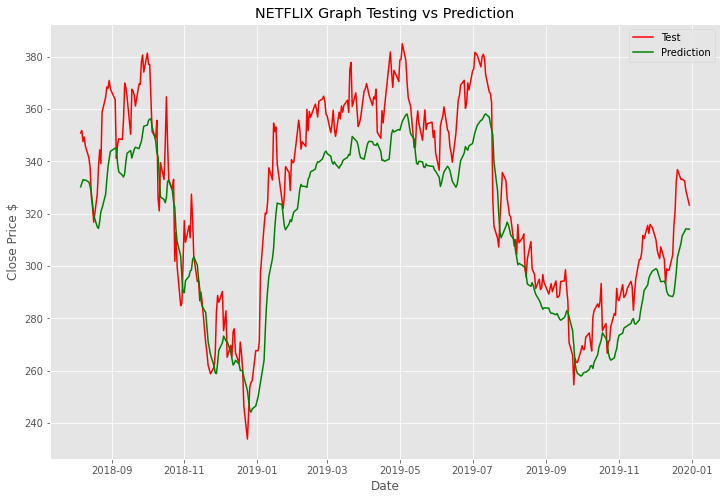

***************FACEBOOK***************
GRU Training RMSE: 21.49
GRU Training MAPE: 4.95
GRU Testing RMSE: 32.65
GRU Training MAPE: 2.68
Fitting/Train Time in Second:136.148961
Test Data Prediction Time in Second:0.185871


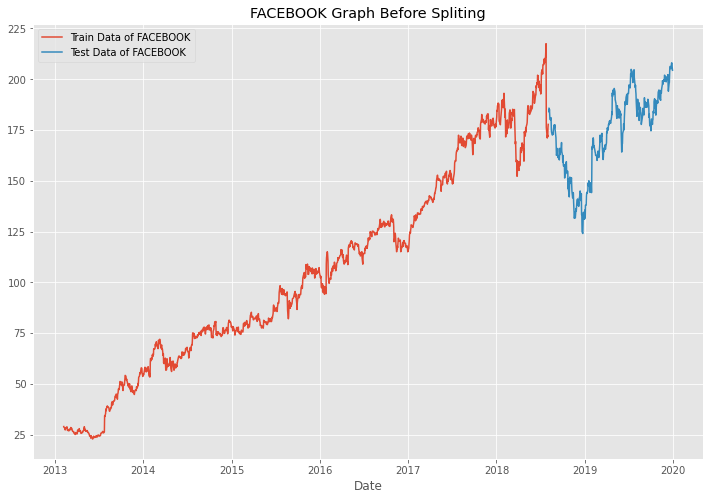

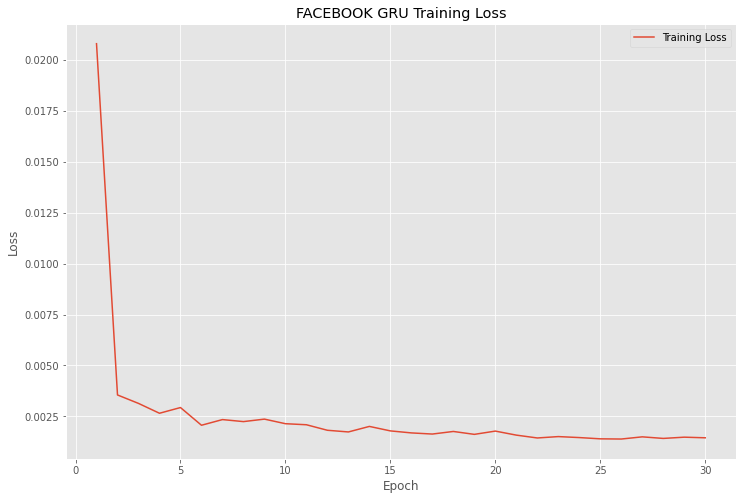

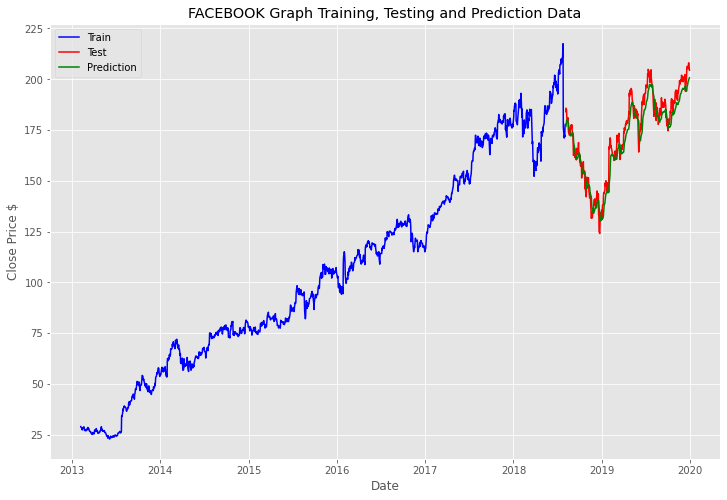

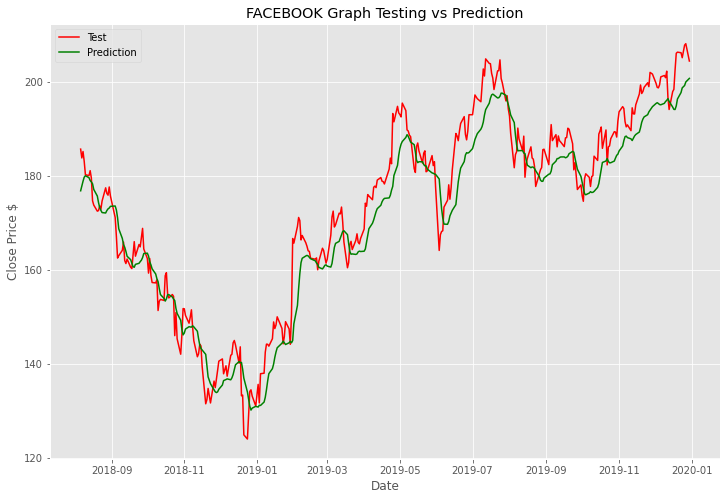

CPU times: user 17min 35s, sys: 48.3 s, total: 18min 23s
Wall time: 11min 16s


In [8]:
%%time
model_name = 'GRU'
Actual_df=pd.read_csv("dataset.csv")
Actual_df.dropna(inplace=True)
company_names=Actual_df['company_name'].unique()
for name in company_names:
    df=Actual_df[Actual_df['company_name']== name]
    time = pd.to_datetime(df.pop('Date'), format='%d/%m/%Y')
    series = df['Close']
    series.index = time
    def split_sequence(sequence, window_size):
      X = []
      y = []
      # for all indexes
      for i in range(len(sequence)):
          end_idx = i + window_size
          # exit condition
          if end_idx > len(sequence)-1:
              break
          # get X and Y values
          seq_x, seq_y = sequence[i:end_idx], sequence[end_idx]
          X.append(seq_x)
          y.append(seq_y)
      return np.array(X), np.array(y)
    train = series[:int(len(series)*0.8)]
    test = series[int(len(series)*0.8)-24:]
    
    X_train, y_train = split_sequence(train, window_size=24)
    X_test, y_test = split_sequence(test, window_size=24)
    
    #Scaling the data using min max saclar between 0 -1
    sc = MinMaxScaler()
    X_train_scaled = sc.fit_transform(X_train)
    X_test_scaled = sc.transform(X_test)
    y_train_scaled = sc.fit_transform(y_train.reshape(-1,1))
    y_test_scaled = sc.transform(y_test.reshape(-1,1))
    
    # Model requires 3D input
    X_train_scaled = X_train_scaled.reshape((len(X_train_scaled), 24, 1)) # window =24 
    X_test_scaled = X_test_scaled.reshape((len(X_test_scaled), 24, 1))    # window =24

    # GRU Model
    model = Sequential()
    model.add(GRU(units=50, return_sequences=True, input_shape=(24,1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(24,1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(24,1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, activation='tanh'))
    model.add(Dropout(0.2))
    # The output layer
    model.add(Dense(units=1))

    #model.summary()
    
    #Optimizer

    opt = Adam(learning_rate=0.001)
    # Model Compile

    model.compile(optimizer= opt, loss='mean_squared_error')
    
    start_fitting = dt.now()
    print("***************"+str(name)+"***************")
    history = model.fit(X_train_scaled, y_train_scaled, epochs=30, batch_size=16,verbose=0)
    
    #Training
    pred_train = model.predict(X_train_scaled)
    pred_transformed_train = sc.inverse_transform(pred_train).ravel()
    y_train_transformed = sc.inverse_transform(y_train_scaled).ravel()
    
    rmse_train = mean_squared_error(y_train_transformed,pred_transformed_train)
    mape_train = mean_absolute_percentage_error(y_train_transformed,pred_transformed_train)
    print('GRU Training RMSE: '+str(round(rmse_train,2)))
    print('GRU Training MAPE: '+str(round(mape_train*100,2)))
    fitting_secs = (dt.now() - start_fitting).total_seconds()
    
    # Testing
    start_x_testing = dt.now()
    pred_test = model.predict(X_test_scaled)
    pred_transformed_test = sc.inverse_transform(pred_test).ravel()
    y_test_transformed = sc.inverse_transform(y_test_scaled).ravel()
    
    rmse_test = mean_squared_error(y_test_transformed,pred_transformed_test)
    mape_test = mean_absolute_percentage_error(y_test_transformed,pred_transformed_test)
    print('GRU Testing RMSE: '+str(round(rmse_test,2)))
    print('GRU Training MAPE: '+str(round(mape_test*100,2)))
    x_testing_secs = (dt.now() - start_x_testing).total_seconds()
    print('Fitting/Train Time in Second:'+str(fitting_secs))
    print('Test Data Prediction Time in Second:'+str(x_testing_secs))
    
    #Spliting Graph
    plt.figure(figsize=(12,8))
    plt.plot(pd.Series(y_train, index=train[24:].index), label='Train Data of'+ ' '+ str(name) )
    plt.plot(pd.Series(y_test, index=test[24:].index), label='Test Data of'+ ' '+ str(name) )
    label=str(name)+' Graph Before Spliting'
    plt.xlabel('Date')
    plt.title(label)
    plt.legend()
    plt.show()
    
   #   #Model Loss
    loss = history.history['loss']
    epoch_count = range(1, len(loss) + 1)
    plt.figure(figsize=(12,8))
    plt.plot(epoch_count, loss)
    plt.legend(['Training Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    label = str(name)+ ' ' + model_name + ' Training Loss'
    plt.title(label)
    plt.show()
    
    #Model Performance Graphs
    plt.figure(figsize=(12,8))
    plt.plot(pd.Series(y_train_transformed, index=train[24:].index),color='blue', label='Train')
    plt.plot(pd.Series(y_test_transformed, index=test[24:].index),color='red', label='Test')
    plt.plot(pd.Series(pred_transformed_test, index=test[24:].index),color='green', label='Prediction')
    plt.xlabel('Date')
    plt.ylabel('Close Price $')
    label=str(name)+' Graph Training, Testing and Prediction Data'
    plt.title(label)
    plt.legend()
    plt.show()

    plt.figure(figsize=(12,8))
    plt.plot(pd.Series(y_test_transformed, index=test[24:].index),color='red', label='Test')
    plt.plot(pd.Series(pred_transformed_test, index=test[24:].index),color='green', label='Prediction')
    plt.xlabel('Date')
    plt.ylabel('Close Price $')
    label=str(name)+' Graph Testing vs Prediction'
    plt.title(label)
    plt.legend()
    plt.show()
    del model
    del history
    results['Model'].append(model_name)
    results['company_name'].append(name)
    results['RMSE_Train'].append(rmse_train)
    results['MAPE_Train'].append(mape_train*100)
    results['RMSE_Test'].append(rmse_test)
    results['MAPE_Test'].append(mape_test*100)
    results['Fit/Train_Time'].append(fitting_secs)
    results['Test/Pred_Time'].append(x_testing_secs)


# FFNN

***************APPLE***************
FFNN Training RMSE: 0.52
FFNN Training MAPE: 2.08
FFNN Testing RMSE: 9.17
FFNN Training MAPE: 3.76
Fitting/Train Time in Second:5.755984
Test Data Prediction Time in Second:0.063892


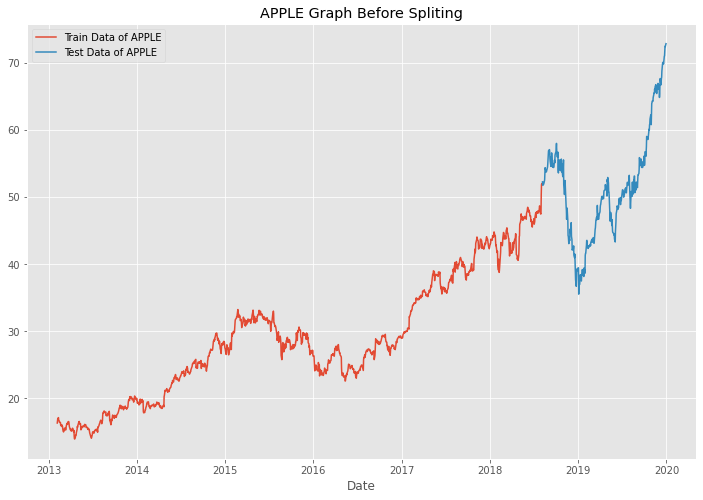

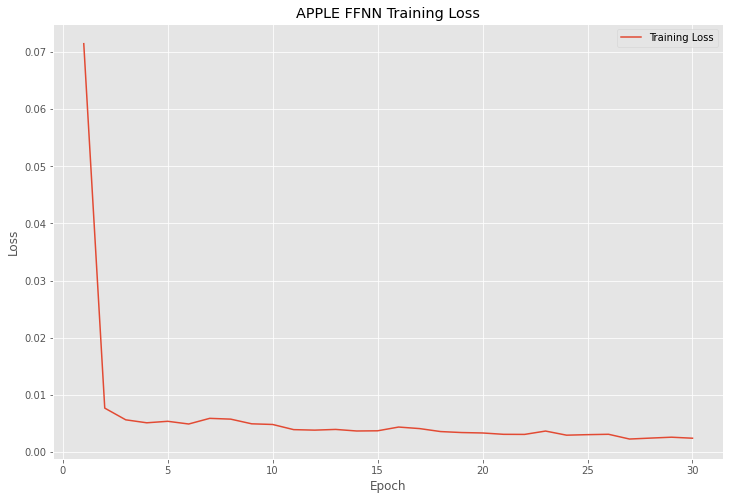

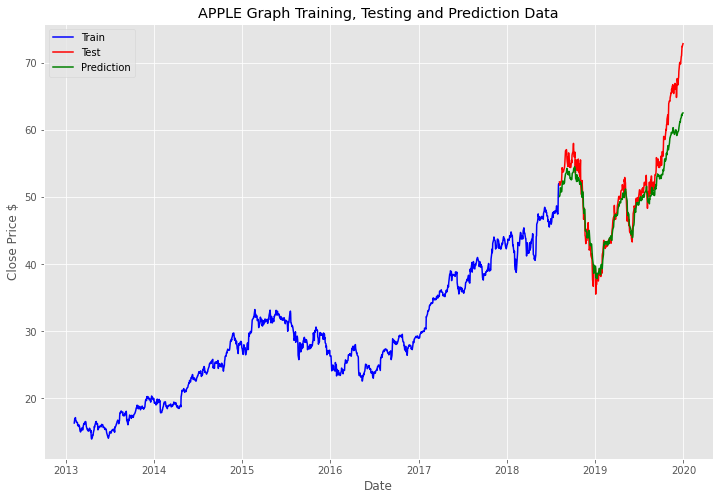

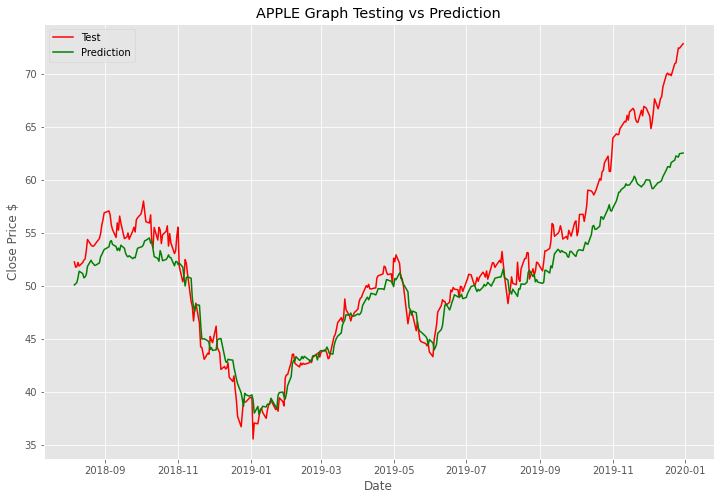

***************GOOGLE***************
FFNN Training RMSE: 172.69
FFNN Training MAPE: 1.28
FFNN Testing RMSE: 593.83
FFNN Training MAPE: 1.65
Fitting/Train Time in Second:5.743255
Test Data Prediction Time in Second:0.071805


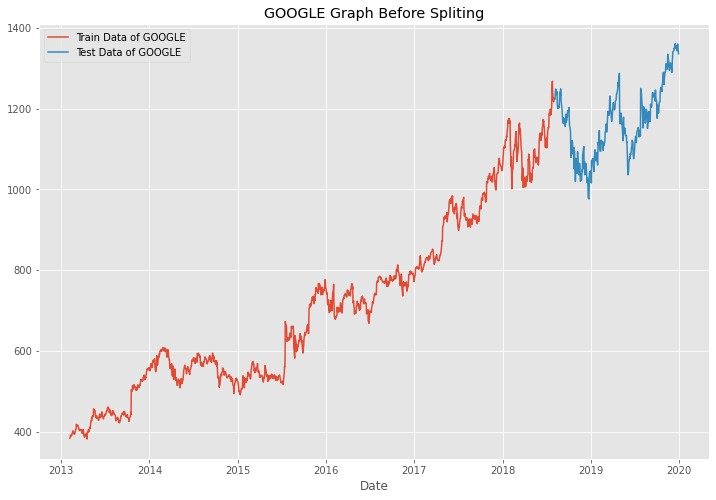

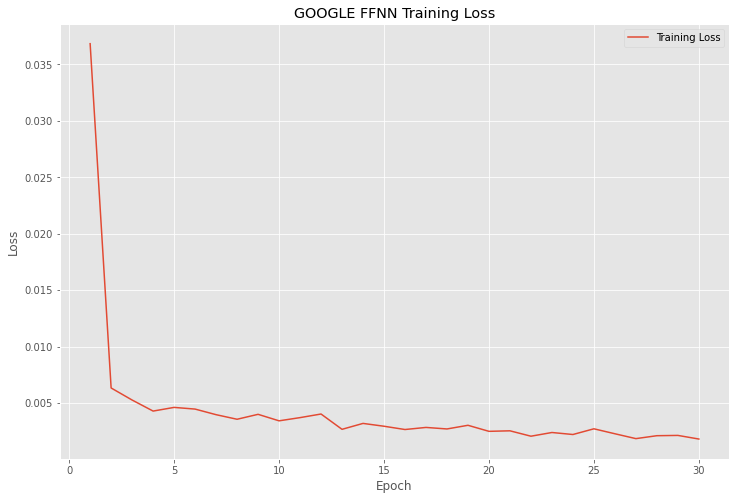

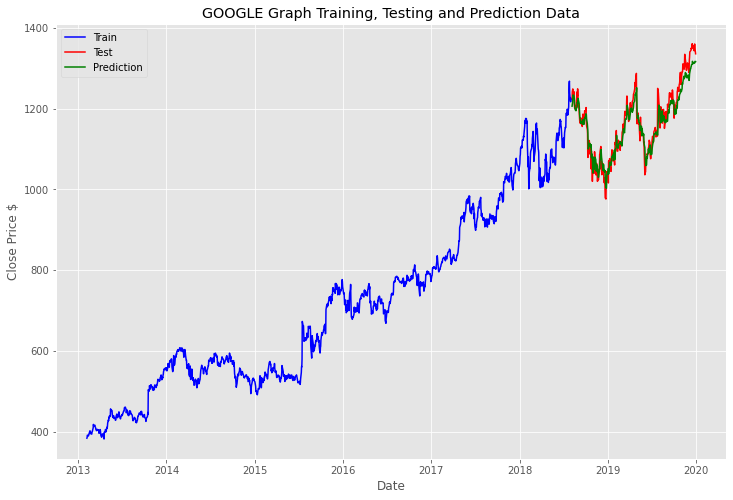

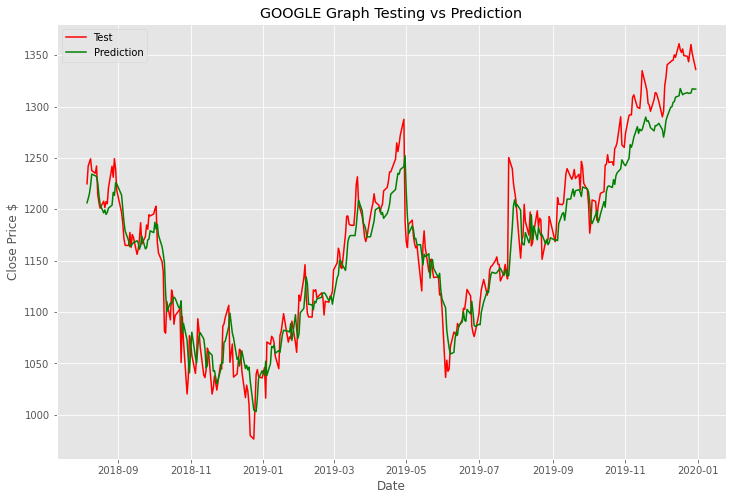

***************AMAZON***************
FFNN Training RMSE: 1.82
FFNN Training MAPE: 2.98
FFNN Testing RMSE: 19.78
FFNN Training MAPE: 4.42
Fitting/Train Time in Second:4.805649
Test Data Prediction Time in Second:0.071324


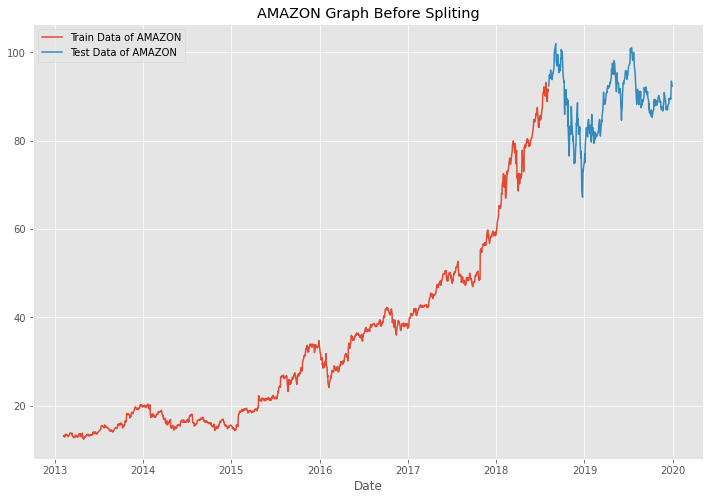

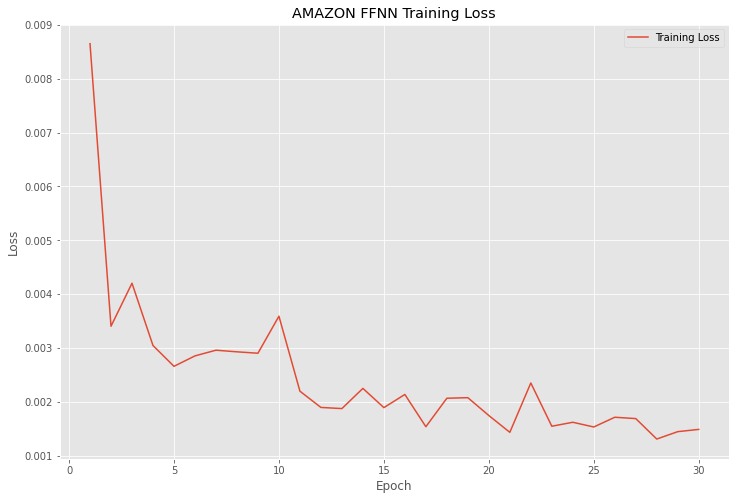

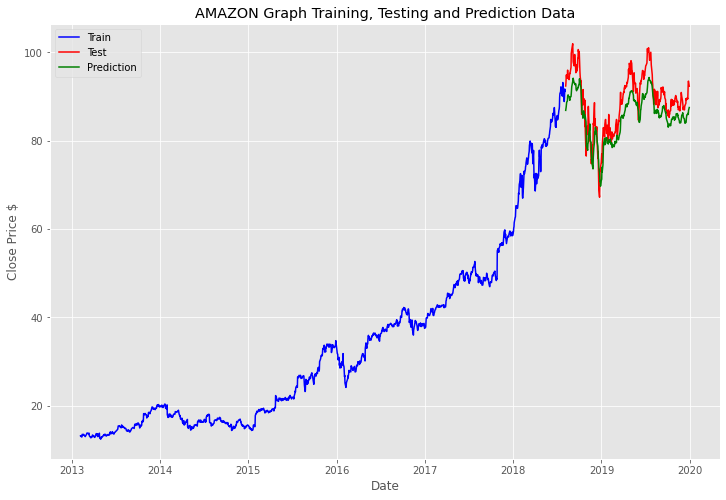

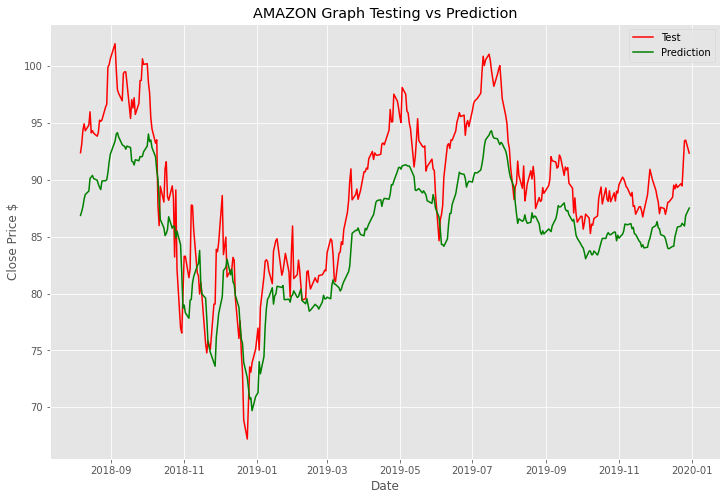

***************NETFLIX***************
FFNN Training RMSE: 102.04
FFNN Training MAPE: 5.28
FFNN Testing RMSE: 532.43
FFNN Training MAPE: 6.32
Fitting/Train Time in Second:5.762482
Test Data Prediction Time in Second:0.079374


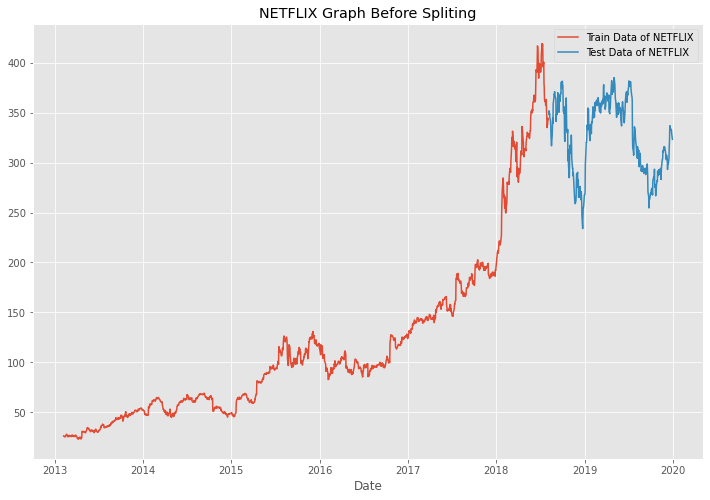

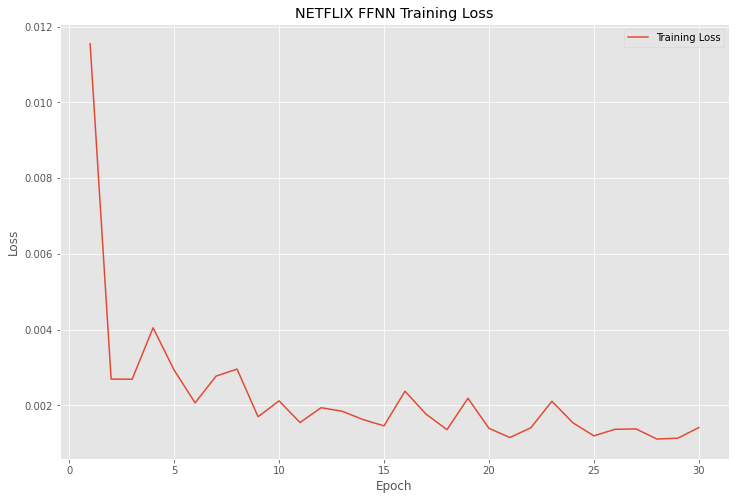

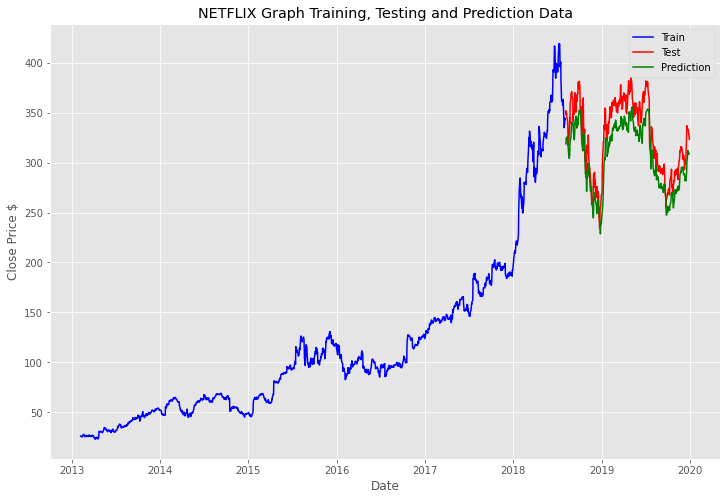

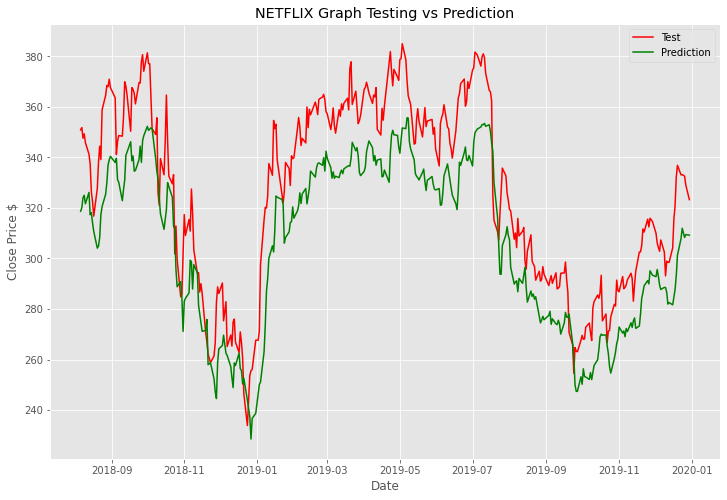

***************FACEBOOK***************
FFNN Training RMSE: 13.65
FFNN Training MAPE: 3.51
FFNN Testing RMSE: 24.71
FFNN Training MAPE: 2.27
Fitting/Train Time in Second:6.560029
Test Data Prediction Time in Second:0.061155


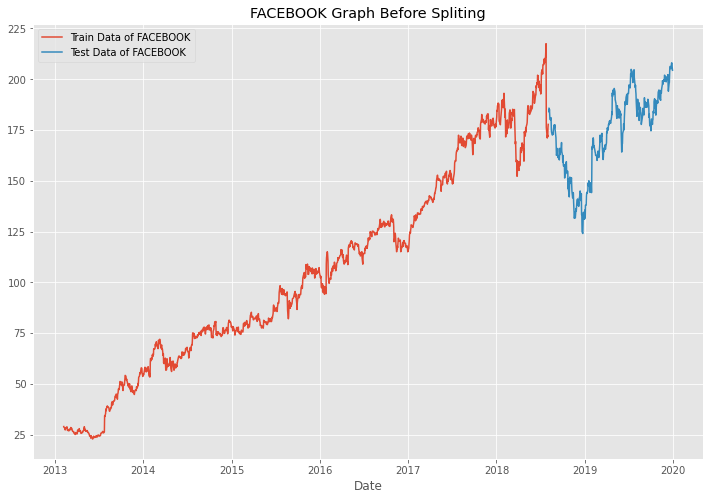

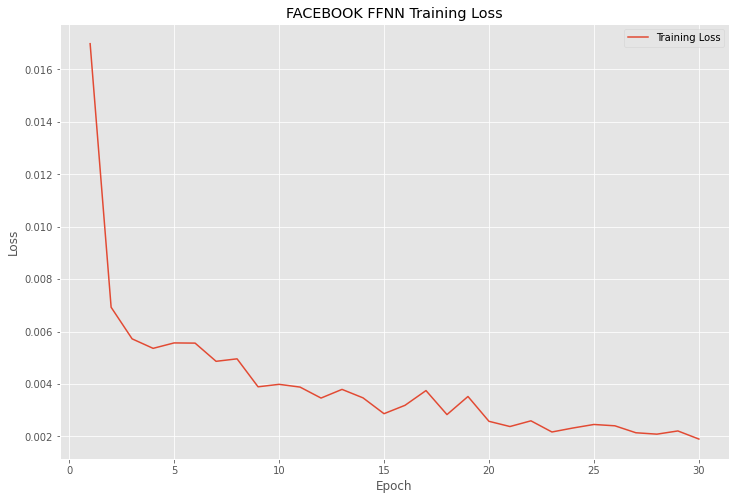

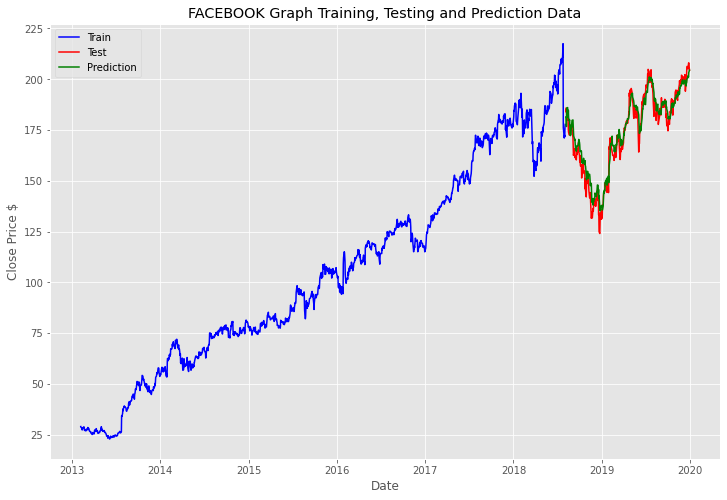

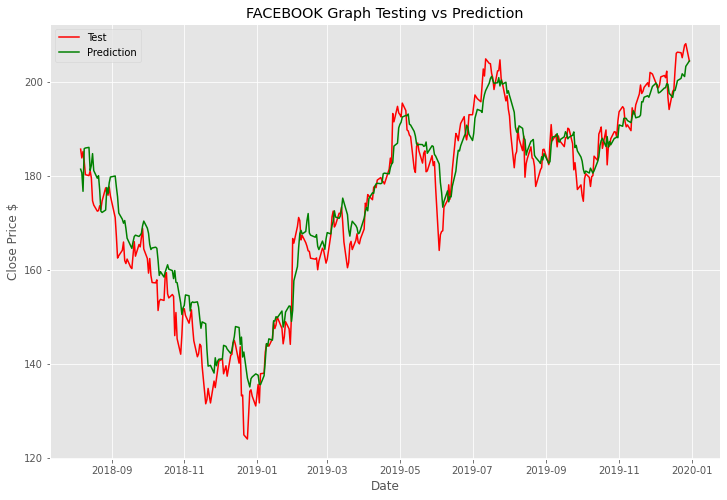

CPU times: user 36.1 s, sys: 2.34 s, total: 38.5 s
Wall time: 35.3 s


In [9]:
%%%time
model_name = 'FFNN'
Actual_df=pd.read_csv("dataset.csv")
Actual_df.dropna(inplace=True)
company_names=Actual_df['company_name'].unique()
for name in company_names:
    df=Actual_df[Actual_df['company_name']== name]
    time = pd.to_datetime(df.pop('Date'), format='%d/%m/%Y')
    series = df['Close']
    series.index = time
    def split_sequence(sequence, window_size):
      X = []
      y = []
      # for all indexes
      for i in range(len(sequence)):
          end_idx = i + window_size
          # exit condition
          if end_idx > len(sequence)-1:
              break
          # get X and Y values
          seq_x, seq_y = sequence[i:end_idx], sequence[end_idx]
          X.append(seq_x)
          y.append(seq_y)
      return np.array(X), np.array(y)
    train = series[:int(len(series)*0.8)]
    test = series[int(len(series)*0.8)-24:]
    
    X_train, y_train = split_sequence(train, window_size=24)
    X_test, y_test = split_sequence(test, window_size=24)
    
    #Scaling the data using min max saclar between 0 -1
    sc = MinMaxScaler()
    X_train_scaled = sc.fit_transform(X_train)
    X_test_scaled = sc.transform(X_test)
    y_train_scaled = sc.fit_transform(y_train.reshape(-1,1))
    y_test_scaled = sc.transform(y_test.reshape(-1,1))
    
    # Model requires 3D input
    X_train_scaled = X_train_scaled.reshape((len(X_train_scaled), 24, 1)) # window =24 
    X_test_scaled = X_test_scaled.reshape((len(X_test_scaled), 24, 1))    # window =24

    # FFNN Model
    model = Sequential()
    model.add(InputLayer(input_shape=(24)))
    model.add(Dense(units=64,activation='tanh'))
    model.add(Dense(units=32,activation='tanh'))
    model.add(Dense(units=16,activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1,activation='linear'))
    #model.summary()
    
    #Optimizer

    opt = Adam(learning_rate=0.001)
    # Model Compile

    model.compile(optimizer= opt, loss='mean_squared_error')
    
    start_fitting = dt.now()
    print("***************"+str(name)+"***************")
    history = model.fit(X_train_scaled, y_train_scaled, epochs=30, batch_size=16,verbose=0)
    
    #Training
    pred_train = model.predict(X_train_scaled)
    pred_transformed_train = sc.inverse_transform(pred_train).ravel()
    y_train_transformed = sc.inverse_transform(y_train_scaled).ravel()
    
    rmse_train = mean_squared_error(y_train_transformed,pred_transformed_train)
    mape_train = mean_absolute_percentage_error(y_train_transformed,pred_transformed_train)
    print('FFNN Training RMSE: '+str(round(rmse_train,2)))
    print('FFNN Training MAPE: '+str(round(mape_train*100,2)))
    fitting_secs = (dt.now() - start_fitting).total_seconds()
    
    # Testing
    start_x_testing = dt.now()
    pred_test = model.predict(X_test_scaled)
    pred_transformed_test = sc.inverse_transform(pred_test).ravel()
    y_test_transformed = sc.inverse_transform(y_test_scaled).ravel()
    
    rmse_test = mean_squared_error(y_test_transformed,pred_transformed_test)
    mape_test = mean_absolute_percentage_error(y_test_transformed,pred_transformed_test)
    print('FFNN Testing RMSE: '+str(round(rmse_test,2)))
    print('FFNN Training MAPE: '+str(round(mape_test*100,2)))
    x_testing_secs = (dt.now() - start_x_testing).total_seconds()
    print('Fitting/Train Time in Second:'+str(fitting_secs))
    print('Test Data Prediction Time in Second:'+str(x_testing_secs))
    
    #Spliting Graph
    plt.figure(figsize=(12,8))
    plt.plot(pd.Series(y_train, index=train[24:].index), label='Train Data of'+ ' '+ str(name) )
    plt.plot(pd.Series(y_test, index=test[24:].index), label='Test Data of'+ ' '+ str(name) )
    label=str(name)+' Graph Before Spliting'
    plt.xlabel('Date')
    plt.title(label)
    plt.legend()
    plt.show()
    
   #   #Model Loss
    loss = history.history['loss']
    epoch_count = range(1, len(loss) + 1)
    plt.figure(figsize=(12,8))
    plt.plot(epoch_count, loss)
    plt.legend(['Training Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    label = str(name)+ ' ' + model_name + ' Training Loss'
    plt.title(label)
    plt.show()
    
    #Model Performance Graphs
    plt.figure(figsize=(12,8))
    plt.plot(pd.Series(y_train_transformed, index=train[24:].index),color='blue', label='Train')
    plt.plot(pd.Series(y_test_transformed, index=test[24:].index),color='red', label='Test')
    plt.plot(pd.Series(pred_transformed_test, index=test[24:].index),color='green', label='Prediction')
    plt.xlabel('Date')
    plt.ylabel('Close Price $')
    label=str(name)+' Graph Training, Testing and Prediction Data'
    plt.title(label)
    plt.legend()
    plt.show()

    plt.figure(figsize=(12,8))
    plt.plot(pd.Series(y_test_transformed, index=test[24:].index),color='red', label='Test')
    plt.plot(pd.Series(pred_transformed_test, index=test[24:].index),color='green', label='Prediction')
    plt.xlabel('Date')
    plt.ylabel('Close Price $')
    label=str(name)+' Graph Testing vs Prediction'
    plt.title(label)
    plt.legend()
    plt.show()
    del model
    del history
    results['Model'].append(model_name)
    results['company_name'].append(name)
    results['RMSE_Train'].append(rmse_train)
    results['MAPE_Train'].append(mape_train*100)
    results['RMSE_Test'].append(rmse_test)
    results['MAPE_Test'].append(mape_test*100)
    results['Fit/Train_Time'].append(fitting_secs)
    results['Test/Pred_Time'].append(x_testing_secs)

# RNN

***************APPLE***************
RNN Training RMSE: 0.53
RNN Training MAPE: 1.97
RNN Testing RMSE: 8.01
RNN Training MAPE: 4.27
Fitting/Train Time in Second:40.141262
Test Data Prediction Time in Second:0.108586


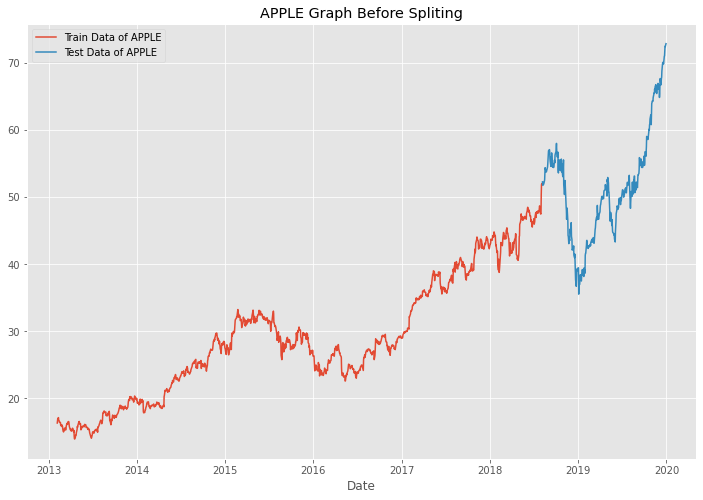

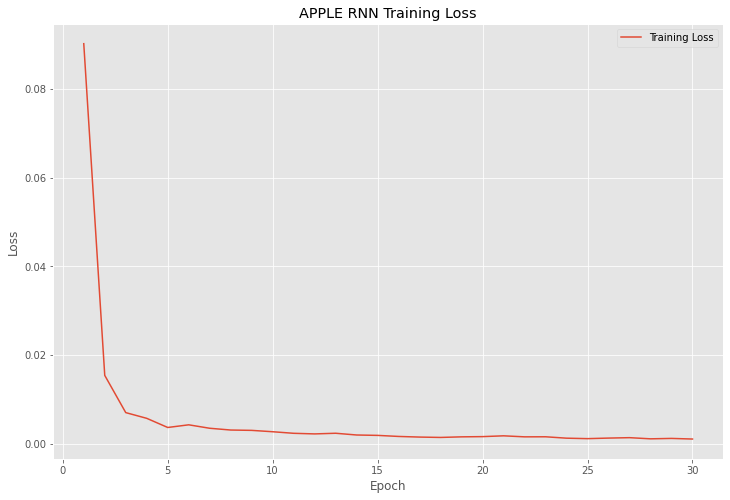

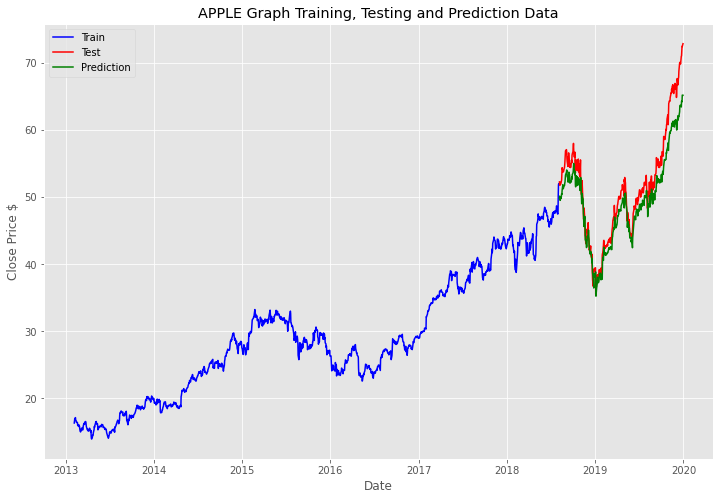

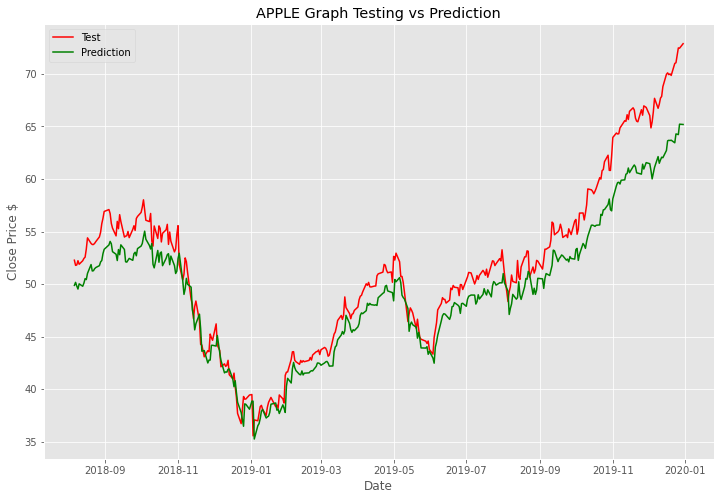

***************GOOGLE***************
RNN Training RMSE: 176.24
RNN Training MAPE: 1.29
RNN Testing RMSE: 866.83
RNN Training MAPE: 2.08
Fitting/Train Time in Second:40.707719
Test Data Prediction Time in Second:0.117825


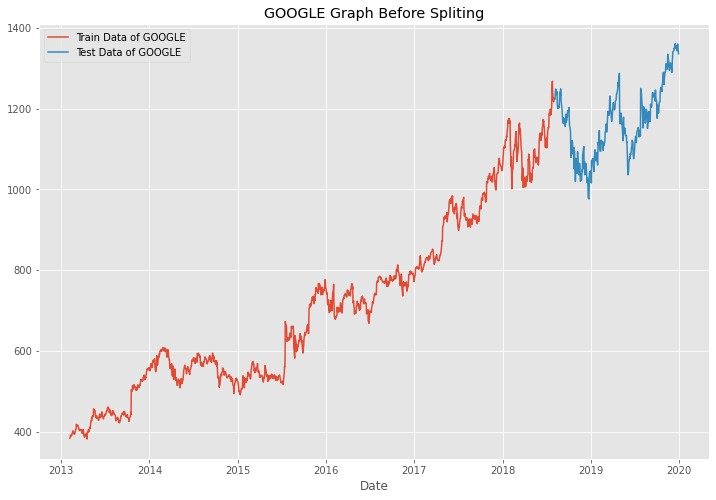

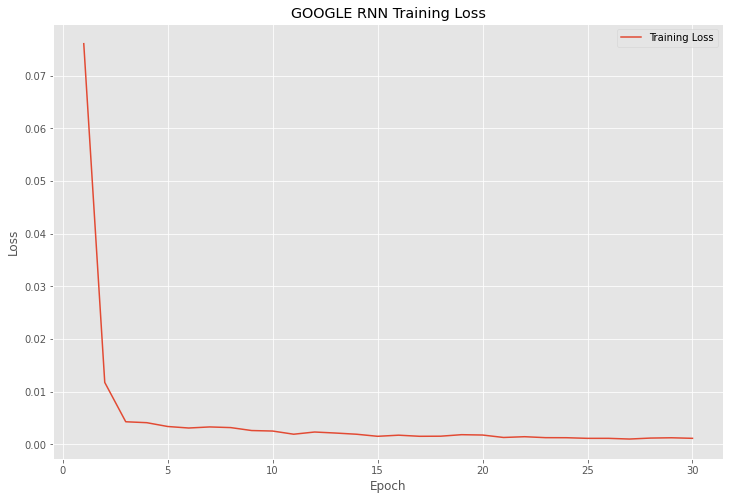

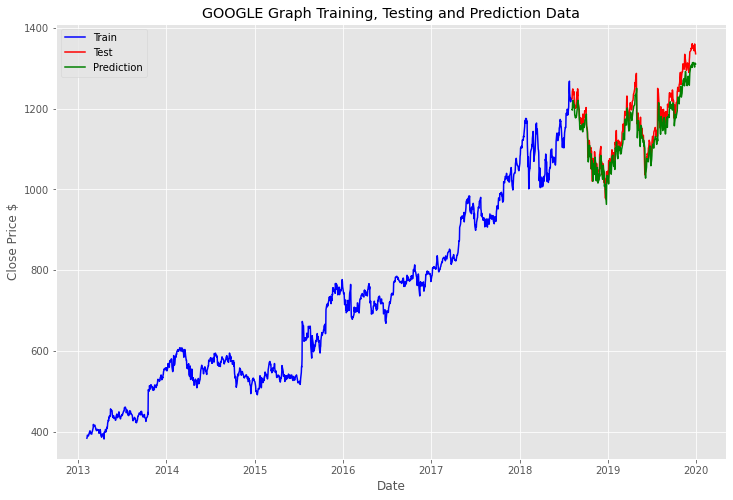

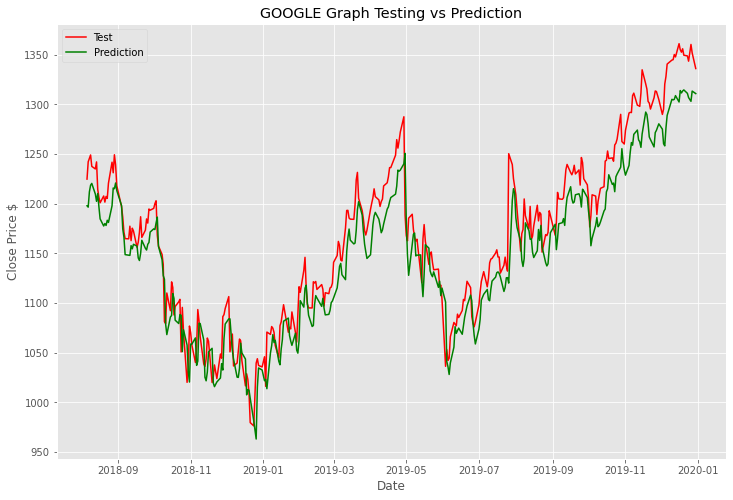

***************AMAZON***************
RNN Training RMSE: 1.81
RNN Training MAPE: 2.51
RNN Testing RMSE: 15.69
RNN Training MAPE: 4.02
Fitting/Train Time in Second:41.508022
Test Data Prediction Time in Second:0.125911


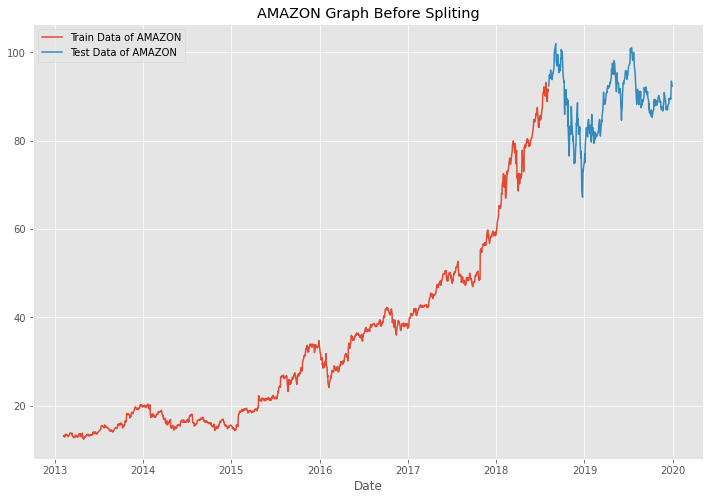

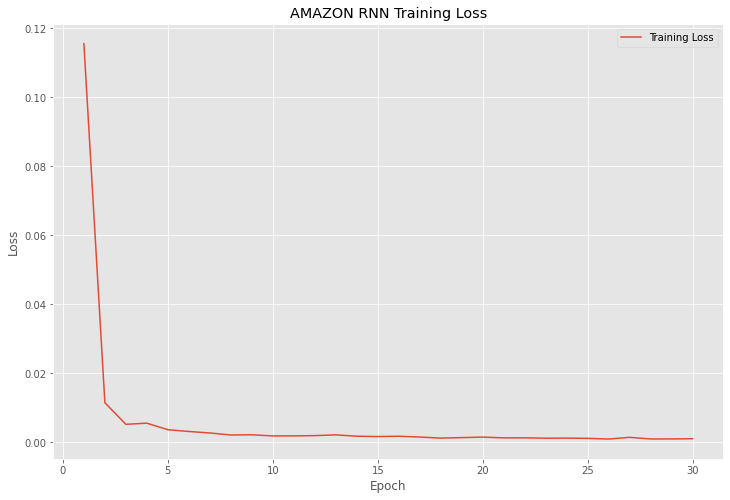

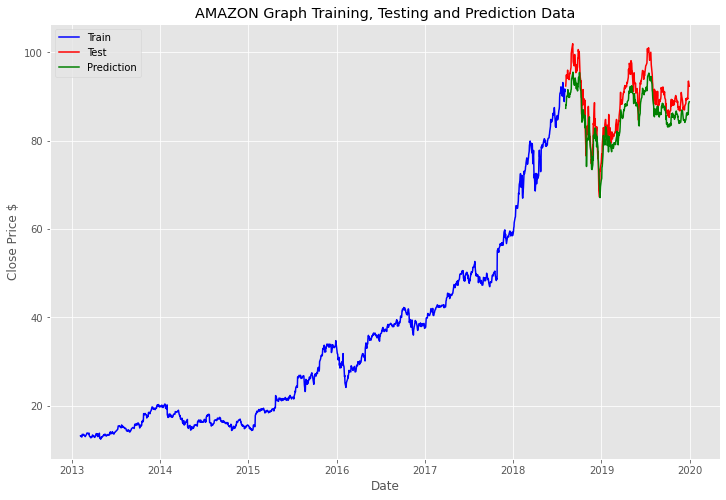

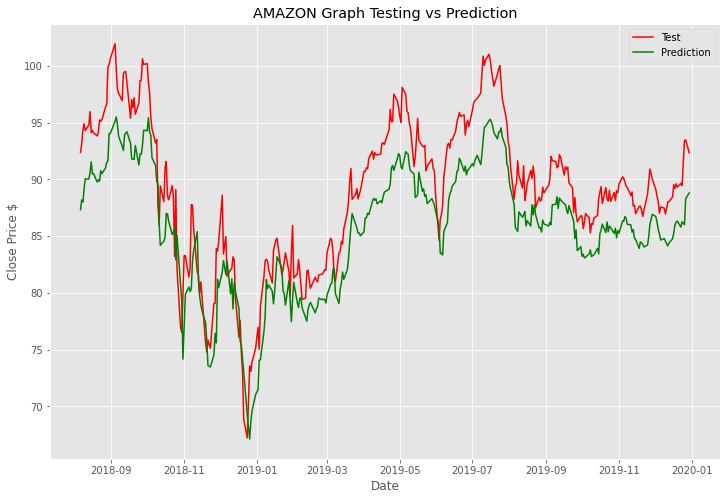

***************NETFLIX***************
RNN Training RMSE: 34.28
RNN Training MAPE: 2.98
RNN Testing RMSE: 174.37
RNN Training MAPE: 3.39
Fitting/Train Time in Second:40.602776
Test Data Prediction Time in Second:0.109402


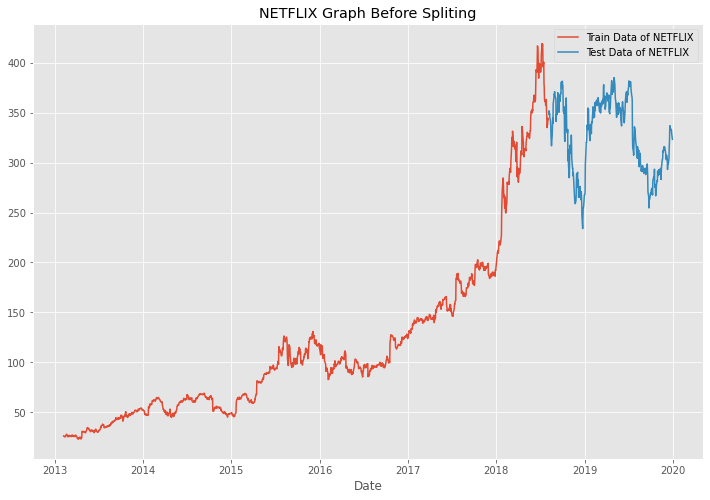

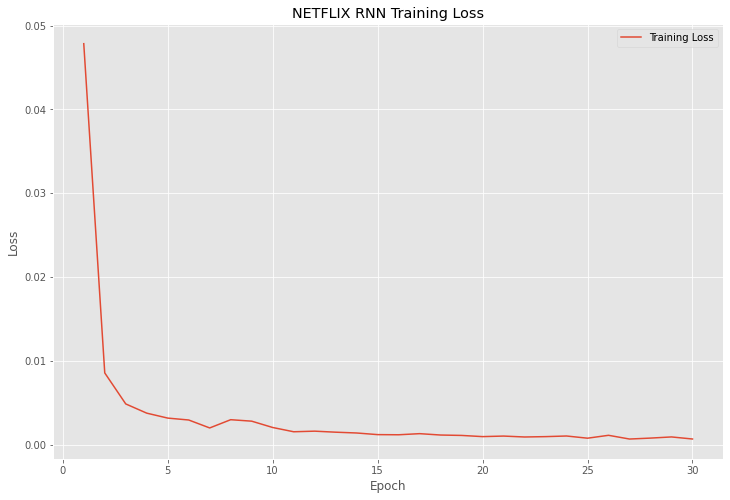

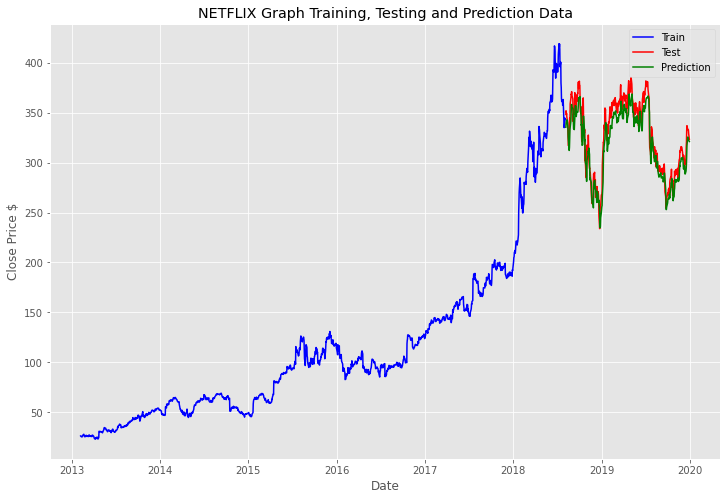

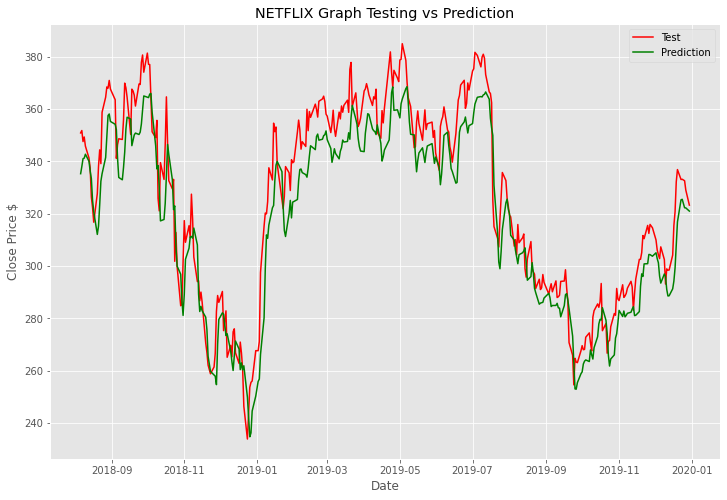

***************FACEBOOK***************
RNN Training RMSE: 15.05
RNN Training MAPE: 2.37
RNN Testing RMSE: 50.08
RNN Training MAPE: 3.47
Fitting/Train Time in Second:41.392495
Test Data Prediction Time in Second:0.104203


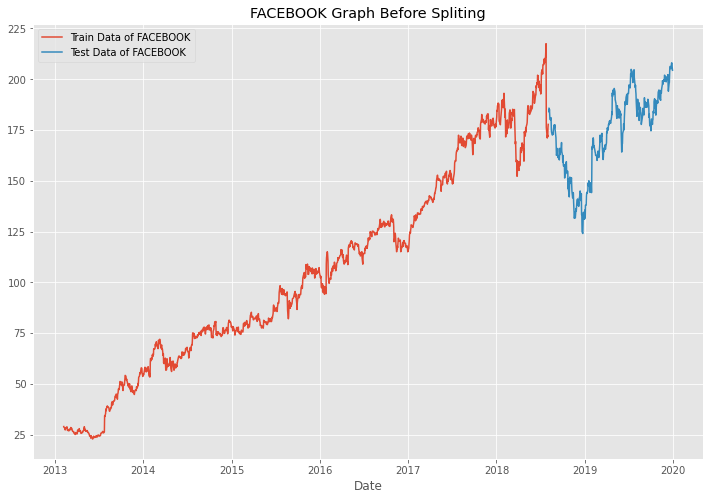

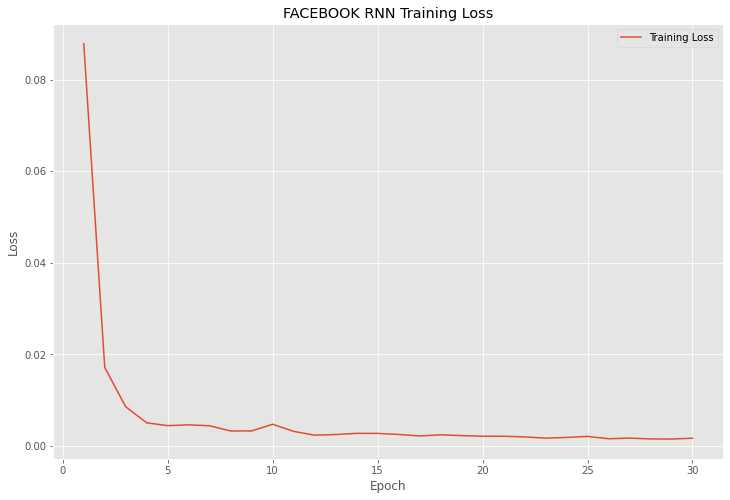

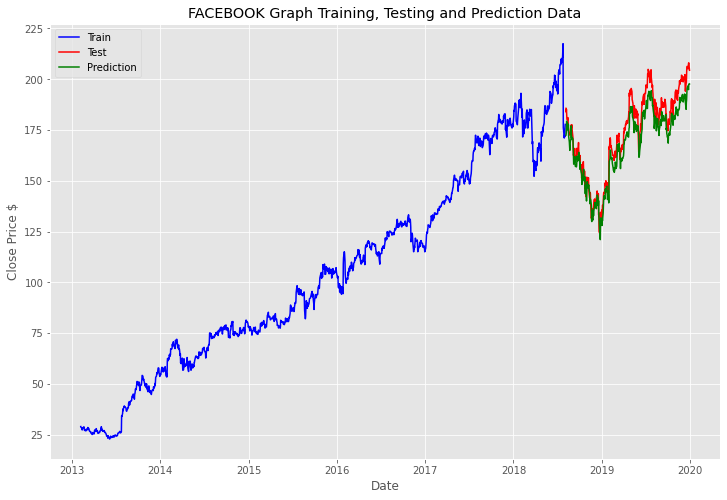

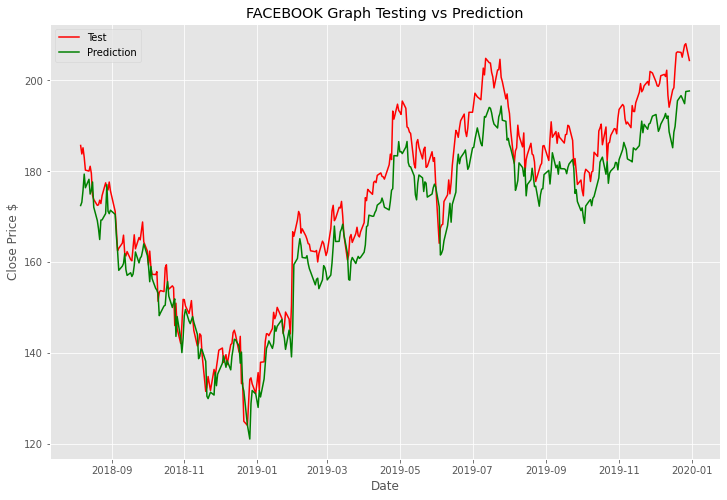

CPU times: user 5min 43s, sys: 17.1 s, total: 6min
Wall time: 3min 31s


In [10]:
%%%time
model_name = 'RNN'
Actual_df=pd.read_csv("dataset.csv")
Actual_df.dropna(inplace=True)
company_names=Actual_df['company_name'].unique()
for name in company_names:
    df=Actual_df[Actual_df['company_name']== name]
    time = pd.to_datetime(df.pop('Date'), format='%d/%m/%Y')
    series = df['Close']
    series.index = time
    def split_sequence(sequence, window_size):
      X = []
      y = []
      # for all indexes
      for i in range(len(sequence)):
          end_idx = i + window_size
          # exit condition
          if end_idx > len(sequence)-1:
              break
          # get X and Y values
          seq_x, seq_y = sequence[i:end_idx], sequence[end_idx]
          X.append(seq_x)
          y.append(seq_y)
      return np.array(X), np.array(y)
    train = series[:int(len(series)*0.8)]
    test = series[int(len(series)*0.8)-24:]
    
    X_train, y_train = split_sequence(train, window_size=24)
    X_test, y_test = split_sequence(test, window_size=24)
    
    #Scaling the data using min max saclar between 0 -1
    sc = MinMaxScaler()
    X_train_scaled = sc.fit_transform(X_train)
    X_test_scaled = sc.transform(X_test)
    y_train_scaled = sc.fit_transform(y_train.reshape(-1,1))
    y_test_scaled = sc.transform(y_test.reshape(-1,1))
    
    # Model requires 3D input
    X_train_scaled = X_train_scaled.reshape((len(X_train_scaled), 24, 1)) # window =24 
    X_test_scaled = X_test_scaled.reshape((len(X_test_scaled), 24, 1))    # window =24
    # RNN Model
    model = Sequential()
    model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(24,1), activation='tanh'))
    model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(24,1), activation='tanh'))
    model.add(SimpleRNN(units=50, return_sequences=False, input_shape=(24,1), activation='tanh'))
    model.add(Dropout(0.2))
# The output layer
    model.add(Dense(units=1))
    #model.summary()
    
    #Optimizer

    opt = Adam(learning_rate=0.001)
    # Model Compile

    model.compile(optimizer= opt, loss='mean_squared_error')
    
    start_fitting = dt.now()
    print("***************"+str(name)+"***************")
    history = model.fit(X_train_scaled, y_train_scaled, epochs=30, batch_size=16,verbose=0)
    
    #Training
    pred_train = model.predict(X_train_scaled)
    pred_transformed_train = sc.inverse_transform(pred_train).ravel()
    y_train_transformed = sc.inverse_transform(y_train_scaled).ravel()
    
    rmse_train = mean_squared_error(y_train_transformed,pred_transformed_train)
    mape_train = mean_absolute_percentage_error(y_train_transformed,pred_transformed_train)
    print('RNN Training RMSE: '+str(round(rmse_train,2)))
    print('RNN Training MAPE: '+str(round(mape_train*100,2)))
    fitting_secs = (dt.now() - start_fitting).total_seconds()
    
    # Testing
    start_x_testing = dt.now()
    pred_test = model.predict(X_test_scaled)
    pred_transformed_test = sc.inverse_transform(pred_test).ravel()
    y_test_transformed = sc.inverse_transform(y_test_scaled).ravel()
    
    rmse_test = mean_squared_error(y_test_transformed,pred_transformed_test)
    mape_test = mean_absolute_percentage_error(y_test_transformed,pred_transformed_test)
    print('RNN Testing RMSE: '+str(round(rmse_test,2)))
    print('RNN Training MAPE: '+str(round(mape_test*100,2)))
    x_testing_secs = (dt.now() - start_x_testing).total_seconds()
    print('Fitting/Train Time in Second:'+str(fitting_secs))
    print('Test Data Prediction Time in Second:'+str(x_testing_secs))
    
    #Spliting Graph
    plt.figure(figsize=(12,8))
    plt.plot(pd.Series(y_train, index=train[24:].index), label='Train Data of'+ ' '+ str(name) )
    plt.plot(pd.Series(y_test, index=test[24:].index), label='Test Data of'+ ' '+ str(name) )
    label=str(name)+' Graph Before Spliting'
    plt.xlabel('Date')
    plt.title(label)
    plt.legend()
    plt.show()
    
   #   #Model Loss
    loss = history.history['loss']
    epoch_count = range(1, len(loss) + 1)
    plt.figure(figsize=(12,8))
    plt.plot(epoch_count, loss)
    plt.legend(['Training Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    label = str(name)+ ' ' + model_name + ' Training Loss'
    plt.title(label)
    plt.show()
    
    #Model Performance Graphs
    plt.figure(figsize=(12,8))
    plt.plot(pd.Series(y_train_transformed, index=train[24:].index),color='blue', label='Train')
    plt.plot(pd.Series(y_test_transformed, index=test[24:].index),color='red', label='Test')
    plt.plot(pd.Series(pred_transformed_test, index=test[24:].index),color='green', label='Prediction')
    plt.xlabel('Date')
    plt.ylabel('Close Price $')
    label=str(name)+' Graph Training, Testing and Prediction Data'
    plt.title(label)
    plt.legend()
    plt.show()

    plt.figure(figsize=(12,8))
    plt.plot(pd.Series(y_test_transformed, index=test[24:].index),color='red', label='Test')
    plt.plot(pd.Series(pred_transformed_test, index=test[24:].index),color='green', label='Prediction')
    plt.xlabel('Date')
    plt.ylabel('Close Price $')
    label=str(name)+' Graph Testing vs Prediction'
    plt.title(label)
    plt.legend()
    plt.show()
    del model
    del history
    results['Model'].append(model_name)
    results['company_name'].append(name)
    results['RMSE_Train'].append(rmse_train)
    results['MAPE_Train'].append(mape_train*100)
    results['RMSE_Test'].append(rmse_test)
    results['MAPE_Test'].append(mape_test*100)
    results['Fit/Train_Time'].append(fitting_secs)
    results['Test/Pred_Time'].append(x_testing_secs)


In [11]:
comparison = pd.DataFrame(results)
display(comparison)

Model company_name  RMSE_Train  MAPE_Train   RMSE_Test  MAPE_Test  \
0   LSTM        APPLE      9.2530      7.1777     88.0834    15.2116   
1   LSTM       GOOGLE   4915.5092      6.2051  21858.6317    11.7694   
2   LSTM       AMAZON     25.1728      9.5704    174.1372    13.7296   
3   LSTM      NETFLIX    418.2255     10.0264   2245.9155    12.8238   
4   LSTM     FACEBOOK    405.9027     12.2063   1168.6515    18.2549   
5    CNN        APPLE      0.4424      1.6904      2.6279     2.3635   
6    CNN       GOOGLE    257.6387      1.6031    834.3609     1.8795   
7    CNN       AMAZON      1.8700      2.6808     16.9351     3.7695   
8    CNN      NETFLIX     57.7296      4.2854    455.9592     5.5739   
9    CNN     FACEBOOK     14.4825      2.7396     32.4726     2.6667   
10   GRU        APPLE      0.8106      2.2510      8.1593     4.4636   
11   GRU       GOOGLE    250.2572      1.5545    864.7744     2.0542   
12   GRU       AMAZON      3.2409      6.9203      9.4077     2.6293   
13   GRU      NETFLIX     77.7778      7.9683    342.0987     4.7778   
14   GRU     FACEBOOK     21.4865      4.9528     32.6497     2.6756   
15  FFNN        APPLE      0.5197      2.0759      9.1686     3.7637   
16  FFNN       GOOGLE    172.6928      1.2811    593.8252     1.6522   
17  FFNN       AMAZON      1.8246      2.9825     19.7766     4.4245   
18  FFNN      NETFLIX    102.0358      5.2809    532.4341     6.3229   
19  FFNN     FACEBOOK     13.6533      3.5125     24.7056     2.2697   
20   RNN        APPLE      0.5325      1.9662      8.0110     4.2724   
21   RNN       GOOGLE    176.2403      1.2875    866.8271     2.0770   
22   RNN       AMAZON      1.8106      2.5147     15.6881     4.0221   
23   RNN      NETFLIX     34.2755      2.9839    174.3710     3.3948   
24   RNN     FACEBOOK     15.0466      2.3734     50.0767     3.4702   

    Fit/Train_Time  Test/Pred_Time  
0         117.4973          0.2045  
1         117.2443          0.1795  
2         114.8762          0.3823  
3         116.2817          0.1815  
4         116.2128          0.1701  
5          10.9188          0.0672  
6          10.8964          0.0715  
7           6.6655          0.1439  
8          11.0864          0.0711  
9           6.1812          0.0666  
10        130.2660          0.1928  
11        132.8829          0.1851  
12        131.0276          0.2000  
13        133.8822          0.1929  
14        136.1490          0.1859  
15          5.7560          0.0639  
16          5.7433          0.0718  
17          4.8056          0.0713  
18          5.7625          0.0794  
19          6.5600          0.0612  
20         40.1413          0.1086  
21         40.7077          0.1178  
22         41.5080          0.1259  
23         40.6028          0.1094  
24         41.3925          0.1042

In [12]:
comparison.groupby(['Model','company_name']).agg(['mean'])

RMSE_Train MAPE_Train   RMSE_Test MAPE_Test Fit/Train_Time  \
                         mean       mean        mean      mean           mean   
Model company_name                                                              
CNN   AMAZON           1.8700     2.6808     16.9351    3.7695         6.6655   
      APPLE            0.4424     1.6904      2.6279    2.3635        10.9188   
      FACEBOOK        14.4825     2.7396     32.4726    2.6667         6.1812   
      GOOGLE         257.6387     1.6031    834.3609    1.8795        10.8964   
      NETFLIX         57.7296     4.2854    455.9592    5.5739        11.0864   
FFNN  AMAZON           1.8246     2.9825     19.7766    4.4245         4.8056   
      APPLE            0.5197     2.0759      9.1686    3.7637         5.7560   
      FACEBOOK        13.6533     3.5125     24.7056    2.2697         6.5600   
      GOOGLE         172.6928     1.2811    593.8252    1.6522         5.7433   
      NETFLIX        102.0358     5.2809    532.4341    6.3229         5.7625   
GRU   AMAZON           3.2409     6.9203      9.4077    2.6293       131.0276   
      APPLE            0.8106     2.2510      8.1593    4.4636       130.2660   
      FACEBOOK        21.4865     4.9528     32.6497    2.6756       136.1490   
      GOOGLE         250.2572     1.5545    864.7744    2.0542       132.8829   
      NETFLIX         77.7778     7.9683    342.0987    4.7778       133.8822   
LSTM  AMAZON          25.1728     9.5704    174.1372   13.7296       114.8762   
      APPLE            9.2530     7.1777     88.0834   15.2116       117.4973   
      FACEBOOK       405.9027    12.2063   1168.6515   18.2549       116.2128   
      GOOGLE        4915.5092     6.2051  21858.6317   11.7694       117.2443   
      NETFLIX        418.2255    10.0264   2245.9155   12.8238       116.2817   
RNN   AMAZON           1.8106     2.5147     15.6881    4.0221        41.5080   
      APPLE            0.5325     1.9662      8.0110    4.2724        40.1413   
      FACEBOOK        15.0466     2.3734     50.0767    3.4702        41.3925   
      GOOGLE         176.2403     1.2875    866.8271    2.0770        40.7077   
      NETFLIX         34.2755     2.9839    174.3710    3.3948        40.6028   

                   Test/Pred_Time  
                             mean  
Model company_name                 
CNN   AMAZON               0.1439  
      APPLE                0.0672  
      FACEBOOK             0.0666  
      GOOGLE               0.0715  
      NETFLIX              0.0711  
FFNN  AMAZON               0.0713  
      APPLE                0.0639  
      FACEBOOK             0.0612  
      GOOGLE               0.0718  
      NETFLIX              0.0794  
GRU   AMAZON               0.2000  
      APPLE                0.1928  
      FACEBOOK             0.1859  
      GOOGLE               0.1851  
      NETFLIX              0.1929  
LSTM  AMAZON               0.3823  
      APPLE                0.2045  
      FACEBOOK             0.1701  
      GOOGLE               0.1795  
      NETFLIX              0.1815  
RNN   AMAZON               0.1259  
      APPLE                0.1086  
      FACEBOOK             0.1042  
      GOOGLE               0.1178  
      NETFLIX              0.1094

**Above comparions shows that after tuning hyperparameters RNN,FFN and CNN are the best performing models with least MAPE values.**
**tuned parameters are**
1. Number of units
2. Number of Layers
3. activation functions
4. Learning Rate
5. Optimizers









